In [1]:
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pyreadstat
import pandas as pd
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth
import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView
from sklearn.base import clone
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

# Data Understanding: 

In [4]:
df, meta = pyreadstat.read_sas7bdat('a2z_insurance.sas7bdat')

In [5]:
df.head()

CustID  FirstPolYear  BirthYear          EducDeg  MonthSal  GeoLivArea  \
0     1.0        1985.0     1982.0  2 - High School    2177.0         1.0   
1     2.0        1981.0     1995.0  2 - High School     677.0         4.0   
2     3.0        1991.0     1970.0        1 - Basic    2277.0         3.0   
3     4.0        1990.0     1981.0      3 - BSc/MSc    1099.0         4.0   
4     5.0        1986.0     1973.0      3 - BSc/MSc    1763.0         4.0   

   Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0       1.0      380.97        0.39     375.85          79.45      146.36   
1       1.0     -131.13        1.12      77.46         416.20      116.69   
2       0.0      504.67        0.28     206.15         224.50      124.58   
3       1.0      -16.99        0.99     182.48          43.35      311.17   
4       1.0       35.23        0.90     338.62          47.80      182.59   

   PremLife  PremWork  
0     47.01     16.89  
1    194.48    106.13  
2     86.35     99.02  
3     35.34     28.34  
4     18.78     41.45

In [6]:
df.shape

(10296, 14)

In [7]:
df.dtypes

CustID           float64
FirstPolYear     float64
BirthYear        float64
EducDeg           object
MonthSal         float64
GeoLivArea       float64
Children         float64
CustMonVal       float64
ClaimsRate       float64
PremMotor        float64
PremHousehold    float64
PremHealth       float64
PremLife         float64
PremWork         float64
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustID         10296 non-null  float64
 1   FirstPolYear   10266 non-null  float64
 2   BirthYear      10279 non-null  float64
 3   EducDeg        10296 non-null  object 
 4   MonthSal       10260 non-null  float64
 5   GeoLivArea     10295 non-null  float64
 6   Children       10275 non-null  float64
 7   CustMonVal     10296 non-null  float64
 8   ClaimsRate     10296 non-null  float64
 9   PremMotor      10262 non-null  float64
 10  PremHousehold  10296 non-null  float64
 11  PremHealth     10253 non-null  float64
 12  PremLife       10192 non-null  float64
 13  PremWork       10210 non-null  float64
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [9]:
df['GeoLivArea'].unique()

array([ 1.,  4.,  3.,  2., nan])

##### Defining metric and non_metric features: 

In [10]:
non_metric_features = ["FirstPolYear", "BirthYear", "EducDeg", "GeoLivArea","Children"]
metric_features = df.columns.drop(non_metric_features).to_list()

### Checking for missing values

In [11]:
# Replace the strange characters by NaN
strange_values_list = ["!","$","%","?","*","+","_","@","€"," ","{", ""]
df.replace(strange_values_list,np.nan, inplace=True)
# count of missing values
df.isna().sum()

CustID             0
FirstPolYear      30
BirthYear         17
EducDeg           17
MonthSal          36
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor         34
PremHousehold      0
PremHealth        43
PremLife         104
PremWork          86
dtype: int64

In [12]:
df.loc[df['PremHousehold']==0]

NumExpr defaulting to 8 threads.


CustID  FirstPolYear  BirthYear          EducDeg  MonthSal  GeoLivArea  \
488    489.0        1977.0     1947.0      3 - BSc/MSc       NaN         3.0   
539    540.0        1979.0     1992.0  2 - High School       NaN         2.0   
629    630.0        1987.0     1968.0      3 - BSc/MSc    2483.0         3.0   
830    831.0        1988.0     1942.0  2 - High School       NaN         4.0   
862    863.0        1987.0     1981.0      3 - BSc/MSc    2127.0         1.0   
912    913.0        1998.0     1980.0  2 - High School    2093.0         4.0   
1059  1060.0        1977.0     1967.0      3 - BSc/MSc    3297.0         1.0   
1133  1134.0        1974.0     1952.0      3 - BSc/MSc    3560.0         2.0   
1160  1161.0        1981.0     1983.0      3 - BSc/MSc       NaN         3.0   
1289  1290.0        1980.0     1944.0      3 - BSc/MSc    3962.0         4.0   
1376  1377.0        1983.0     1977.0      3 - BSc/MSc    1460.0         3.0   
1780  1781.0        1998.0     1964.0      3 - BSc/MSc       NaN         1.0   
1816  1817.0        1978.0     1959.0      3 - BSc/MSc       NaN         2.0   
2226  2227.0        1976.0     1952.0  2 - High School    2825.0         4.0   
2564  2565.0        1992.0     1941.0      3 - BSc/MSc    4843.0         4.0   
2593  2594.0        1994.0     1948.0  2 - High School    3745.0         4.0   
2721  2722.0        1996.0     1971.0      3 - BSc/MSc    2596.0         4.0   
2891  2892.0        1985.0     1982.0      3 - BSc/MSc    1343.0         1.0   
3129  3130.0        1982.0     1968.0      3 - BSc/MSc    2827.0         4.0   
3165  3166.0        1995.0     1981.0  2 - High School    1813.0         4.0   
3227  3228.0        1990.0     1949.0          4 - PhD       NaN         1.0   
3317  3318.0        1980.0     1943.0  2 - High School       NaN         2.0   
3450  3451.0        1977.0     1966.0      3 - BSc/MSc    3094.0         4.0   
3972  3973.0        1988.0     1979.0  2 - High School       NaN         4.0   
4022  4023.0        1995.0     1988.0      3 - BSc/MSc    1296.0         3.0   
4113  4114.0        1991.0     1993.0  2 - High School    1073.0         1.0   
4271  4272.0        1983.0     1988.0      3 - BSc/MSc    1458.0         1.0   
4625  4626.0        1978.0     1981.0      3 - BSc/MSc       NaN         4.0   
4861  4862.0        1987.0     1955.0      3 - BSc/MSc    2740.0         1.0   
4908  4909.0        1974.0     1982.0          4 - PhD    1826.0         3.0   
5049  5050.0        1984.0     1971.0  2 - High School    2923.0         4.0   
5082  5083.0        1986.0     1953.0  2 - High School       NaN         4.0   
5396  5397.0        1977.0     1982.0      3 - BSc/MSc       NaN         4.0   
5399  5400.0        1983.0     1969.0  2 - High School    2697.0         2.0   
5538  5539.0        1983.0     1984.0      3 - BSc/MSc       NaN         3.0   
5846  5847.0        1985.0     1936.0  2 - High School    3812.0         1.0   
5983  5984.0        1986.0     1959.0      3 - BSc/MSc    2745.0         3.0   
6400  6401.0        1982.0     1962.0      3 - BSc/MSc    2643.0         3.0   
6439  6440.0        1991.0     1956.0      3 - BSc/MSc    2375.0         2.0   
6461  6462.0        1976.0     1984.0      3 - BSc/MSc       NaN         4.0   
6560  6561.0        1976.0     1992.0              NaN       NaN         4.0   
6614  6615.0        1995.0     1997.0        1 - Basic    1231.0         1.0   
6728  6729.0        1980.0     1960.0      3 - BSc/MSc    2701.0         1.0   
7590  7591.0        1978.0     1972.0      3 - BSc/MSc    2198.0         4.0   
7892  7893.0        1986.0     1991.0      3 - BSc/MSc       NaN         2.0   
8144  8145.0        1985.0     1974.0  2 - High School    1507.0         4.0   
8534  8535.0        1976.0     1943.0      3 - BSc/MSc    3607.0         3.0   
8585  8586.0        1997.0     1950.0      3 - BSc/MSc    3269.0         1.0   
8658  8659.0        1990.0     1971.0      3 - BSc/MSc    2088.0         4.0   
8676  

In [13]:
df.loc[df['PremWork']==0]

Empty DataFrame
Columns: [CustID, FirstPolYear, BirthYear, EducDeg, MonthSal, GeoLivArea, Children, CustMonVal, ClaimsRate, PremMotor, PremHousehold, PremHealth, PremLife, PremWork]
Index: []

The only premium with no missing values is PremHouseHold, this premium is the only one containing 0s as well. 

### Checking for any duplicates

In [14]:
duplicate=df.duplicated()
print(duplicate.sum())
df[duplicate]

0


Empty DataFrame
Columns: [CustID, FirstPolYear, BirthYear, EducDeg, MonthSal, GeoLivArea, Children, CustMonVal, ClaimsRate, PremMotor, PremHousehold, PremHealth, PremLife, PremWork]
Index: []

In [15]:
pd.options.display.max_columns = None
df[metric_features].describe()

CustID      MonthSal     CustMonVal    ClaimsRate     PremMotor  \
count  10296.00000  10260.000000   10296.000000  10296.000000  10262.000000   
mean    5148.50000   2506.667057     177.892605      0.742772    300.470252   
std     2972.34352   1157.449634    1945.811505      2.916964    211.914997   
min        1.00000    333.000000 -165680.420000      0.000000     -4.110000   
25%     2574.75000   1706.000000      -9.440000      0.390000    190.590000   
50%     5148.50000   2501.500000     186.870000      0.720000    298.610000   
75%     7722.25000   3290.250000     399.777500      0.980000    408.300000   
max    10296.00000  55215.000000   11875.890000    256.200000  11604.420000   

       PremHousehold    PremHealth      PremLife      PremWork  
count   10296.000000  10253.000000  10192.000000  10210.000000  
mean      210.431192    171.580833     41.855782     41.277514  
std       352.595984    296.405976     47.480632     51.513572  
min       -75.000000     -2.110000     -7.000000    -12.000000  
25%        49.450000    111.800000      9.890000     10.670000  
50%       132.800000    162.810000     25.560000     25.670000  
75%       290.050000    219.820000     57.790000     56.790000  
max     25048.800000  28272.000000    398.300000   1988.700000

### Checking variables' correlation

In [16]:
df.corr().round(2)

CustID  FirstPolYear  BirthYear  MonthSal  GeoLivArea  \
CustID           1.00          0.01       0.01     -0.01       -0.01   
FirstPolYear     0.01          1.00      -0.01      0.01       -0.01   
BirthYear        0.01         -0.01       1.00     -0.70       -0.02   
MonthSal        -0.01          0.01      -0.70      1.00        0.02   
GeoLivArea      -0.01         -0.01      -0.02      0.02        1.00   
Children        -0.00         -0.02       0.44     -0.39       -0.02   
CustMonVal       0.03          0.00       0.00     -0.00       -0.01   
ClaimsRate      -0.03         -0.00       0.00     -0.00        0.01   
PremMotor       -0.01          0.00      -0.16      0.14        0.00   
PremHousehold    0.02         -0.01       0.15     -0.13        0.01   
PremHealth       0.01          0.00       0.00     -0.00        0.00   
PremLife         0.01         -0.00       0.23     -0.20        0.01   
PremWork         0.02         -0.00       0.21     -0.17        0.00   

               Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
CustID            -0.00        0.03       -0.03      -0.01           0.02   
FirstPolYear      -0.02        0.00       -0.00       0.00          -0.01   
BirthYear          0.44        0.00        0.00      -0.16           0.15   
MonthSal          -0.39       -0.00       -0.00       0.14          -0.13   
GeoLivArea        -0.02       -0.01        0.01       0.00           0.01   
Children           1.00       -0.00       -0.00       0.16          -0.06   
CustMonVal        -0.00        1.00       -0.99       0.03           0.03   
ClaimsRate        -0.00       -0.99        1.00      -0.01          -0.01   
PremMotor          0.16        0.03       -0.01       1.00          -0.28   
PremHousehold     -0.06        0.03       -0.01      -0.28           1.00   
PremHealth        -0.07        0.00        0.01      -0.08           0.02   
PremLife          -0.12        0.01        0.00      -0.41           0.26   
PremWork          -0.09        0.02       -0.00      -0.35           0.24   

               PremHealth  PremLife  PremWork  
CustID               0.01      0.01      0.02  
FirstPolYear         0.00     -0.00     -0.00  
BirthYear            0.00      0.23      0.21  
MonthSal            -0.00     -0.20     -0.17  
GeoLivArea           0.00      0.01      0.00  
Children            -0.07     -0.12     -0.09  
CustMonVal           0.00      0.01      0.02  
ClaimsRate           0.01      0.00     -0.00  
PremMotor           -0.08     -0.41     -0.35  
PremHousehold        0.02      0.26      0.24  
PremHealth           1.00      0.03      0.08  
PremLife             0.03      1.00      0.34  
PremWork             0.08      0.34      1.00

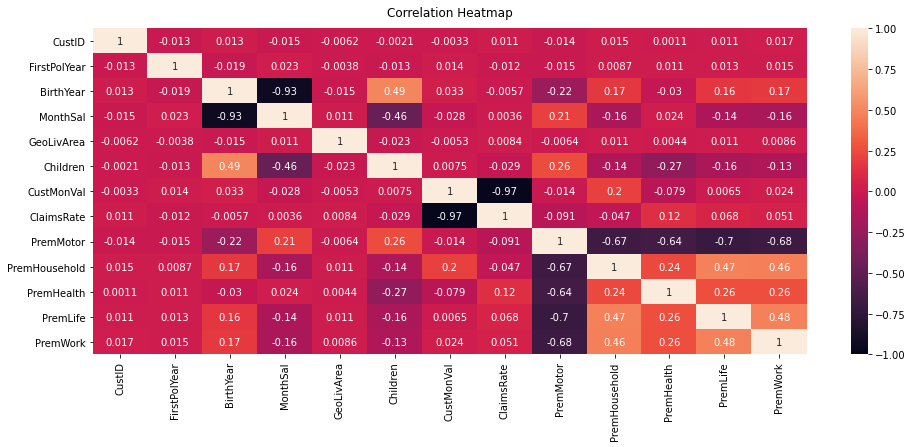

In [17]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(method='spearman'), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Variables distribution

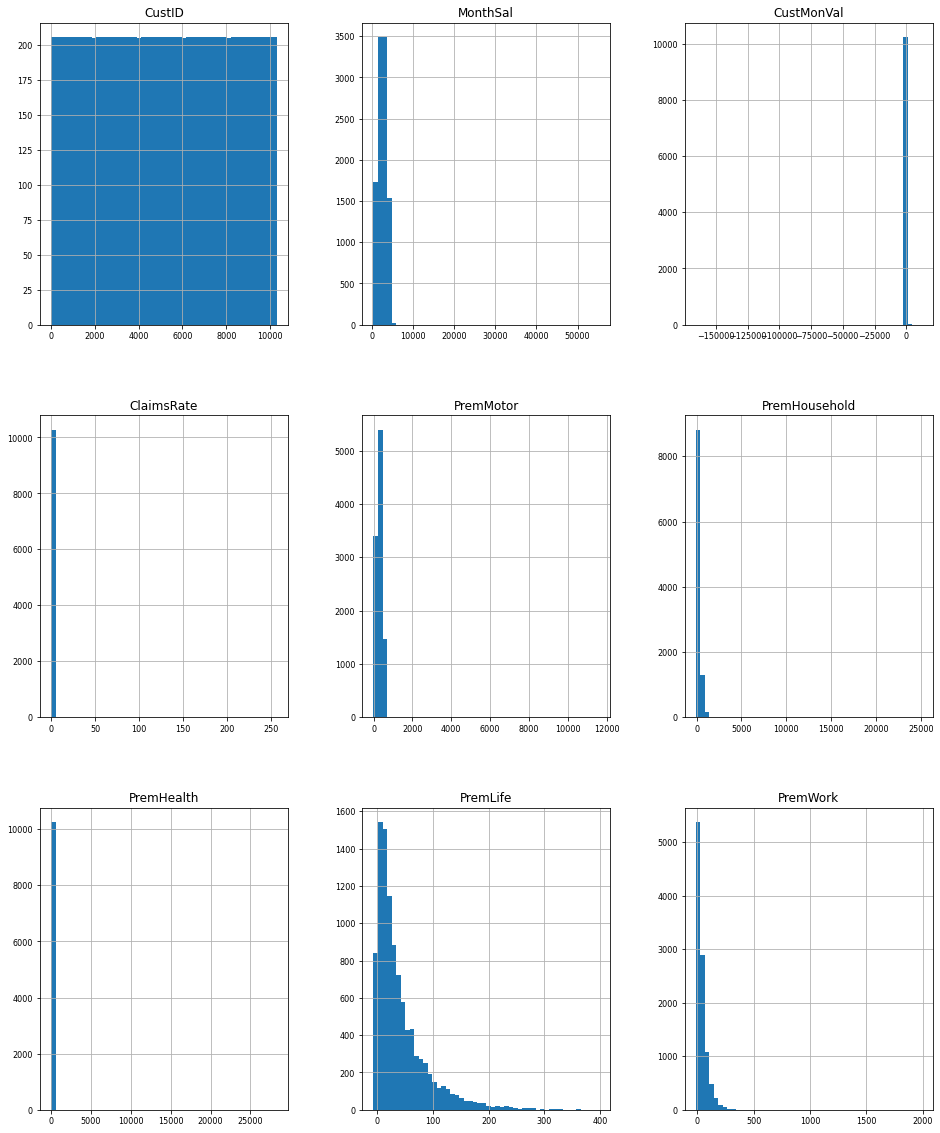

In [18]:
df[metric_features].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

### Categorical Variables'  Frequencies


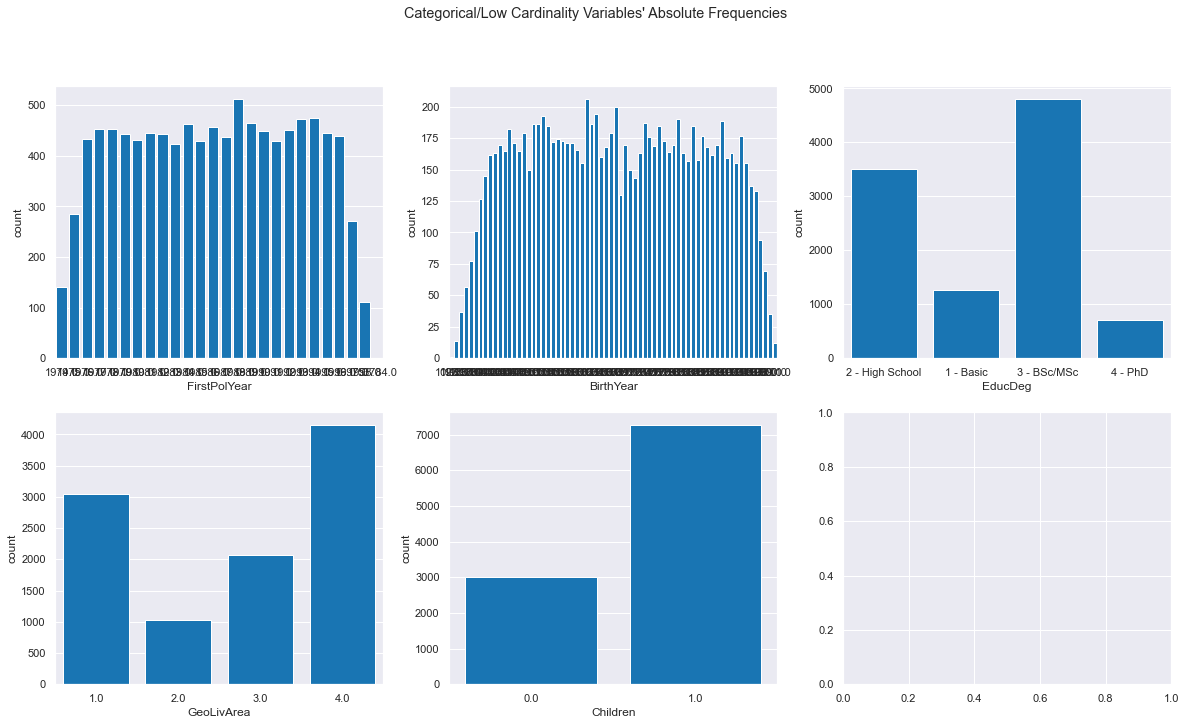

In [19]:
# All Non-Metric Variables' Absolute Frequencies
sns.set()

# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(2, ceil(len(non_metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each bar plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), non_metric_features): # Notice the zip() function and flatten() method
    sns.countplot(df[feat].astype(object), ax=ax, color='#007acc')

title = "Categorical/Low Cardinality Variables' Absolute Frequencies"
plt.suptitle(title)
plt.show()

### Checking for outliers

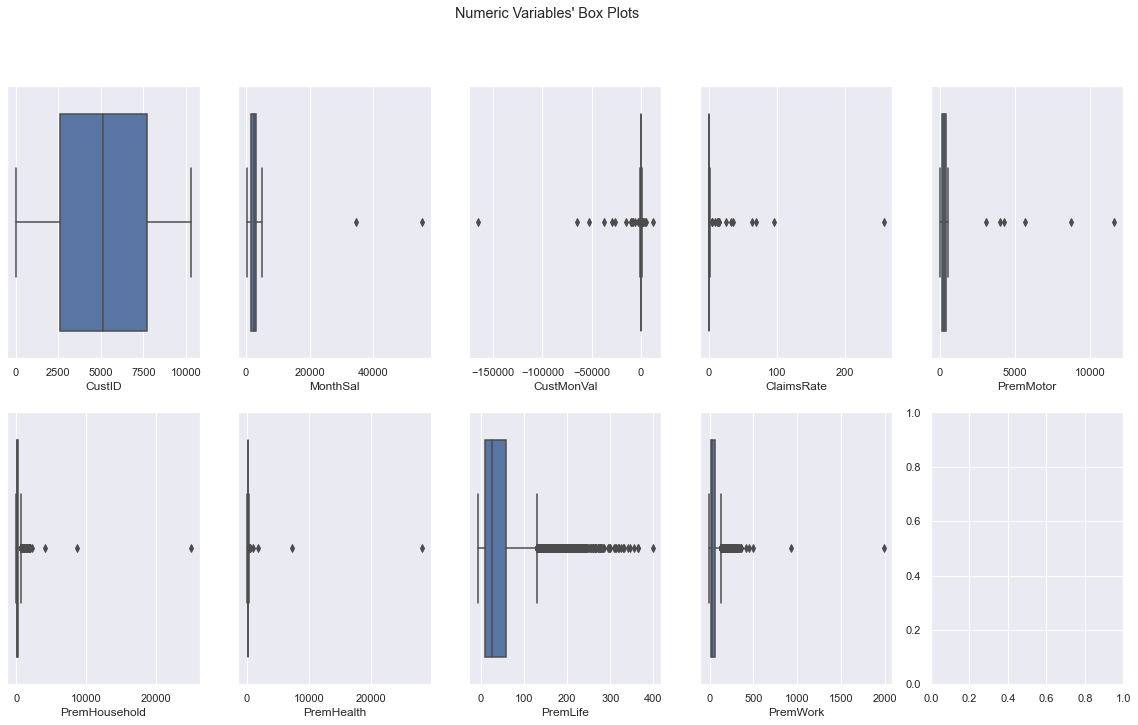

In [20]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(x=df[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

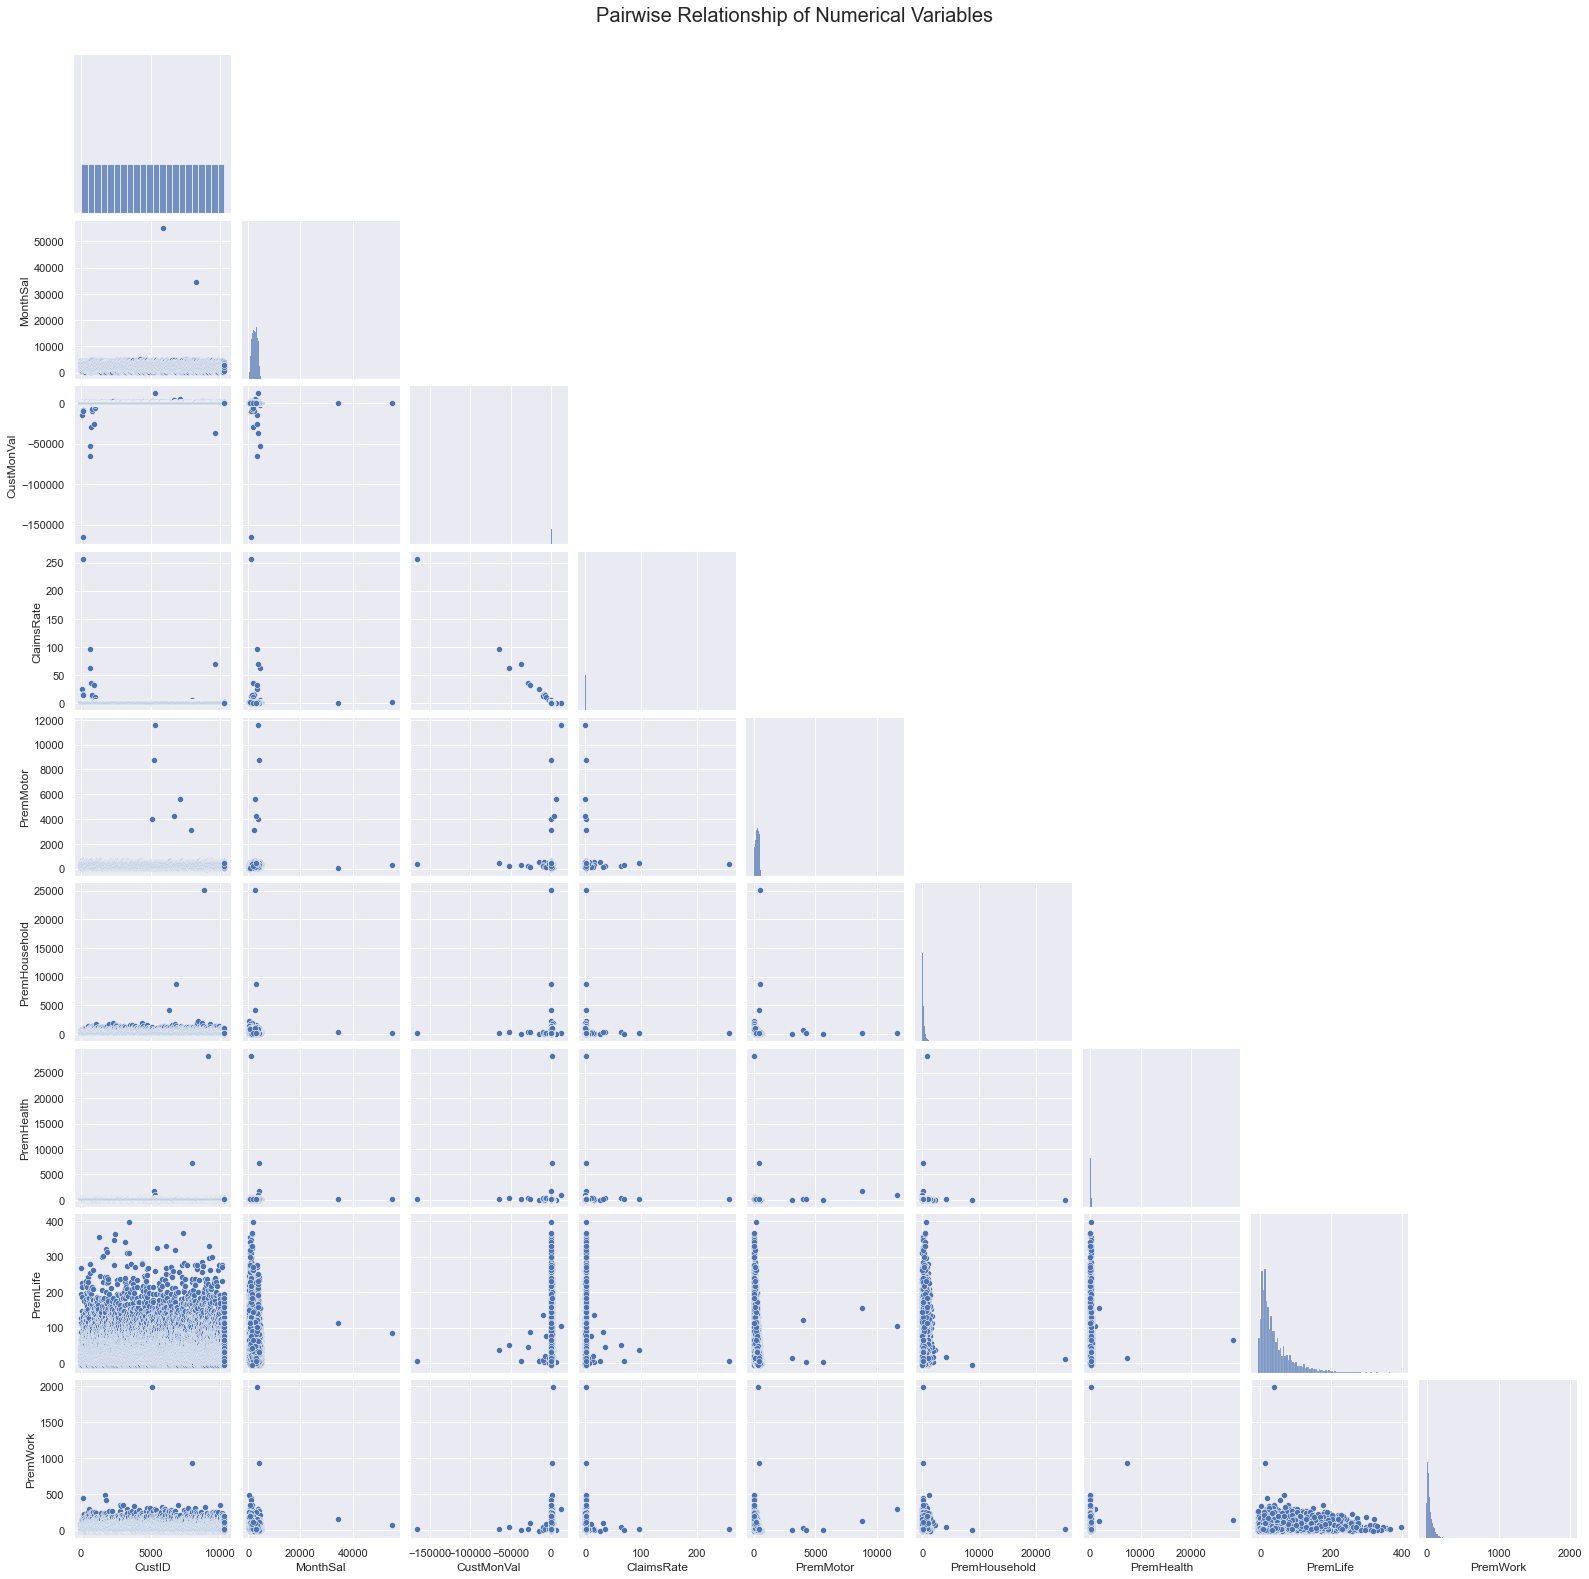

In [21]:
# Pairwise Relationship of Numerical Variables
sns.set()

# Setting pairplot
sns.pairplot(df[metric_features], diag_kind="hist", corner=True)

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)

plt.show()

### Coherence Check: 

In [22]:
df_original=df.copy()

In [23]:
# This database is from 2016, so we can't have values of FirstPolYear bigger than 2016
df.loc[df["FirstPolYear"]>2016]

CustID  FirstPolYear  BirthYear      EducDeg  MonthSal  GeoLivArea  \
9294  9295.0       53784.0     1948.0  3 - BSc/MSc    3268.0         1.0   

      Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
9294       0.0      348.85        0.37      351.4           15.0      187.37   

      PremLife  PremWork  
9294     22.45     17.78

In [24]:
# This code shows that we have 116 minors in the database, in 2016
df.loc[2016-df["BirthYear"]<18]

CustID  FirstPolYear  BirthYear    EducDeg  MonthSal  GeoLivArea  \
13        14.0        1983.0     2000.0  1 - Basic    1043.0         3.0   
186      187.0        1993.0     1999.0  1 - Basic    1247.0         2.0   
397      398.0        1986.0     2000.0  1 - Basic     415.0         1.0   
480      481.0        1984.0     1999.0  1 - Basic    1581.0         4.0   
526      527.0        1982.0     1999.0  1 - Basic     840.0         4.0   
...        ...           ...        ...        ...       ...         ...   
9936    9937.0        1989.0     1999.0  1 - Basic     918.0         3.0   
9947    9948.0        1987.0     2000.0  1 - Basic     422.0         1.0   
10043  10044.0        1983.0     1999.0  1 - Basic    1110.0         1.0   
10121  10122.0        1978.0     1999.0  1 - Basic     738.0         4.0   
10290  10291.0        1994.0     1999.0  1 - Basic     626.0         3.0   

       Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
13          1.0      -75.12        1.06      44.34         342.85      127.69   
186         1.0     -128.24        1.07      33.23        1026.30       82.57   
397         1.0     -218.48        1.22      52.01         348.40       49.01   
480         1.0      866.27        0.21      30.34         683.45       98.13   
526         1.0      -23.54        1.00     132.69         165.60      137.36   
...         ...         ...         ...        ...            ...         ...   
9936        1.0      738.24        0.20      29.45         457.85      117.69   
9947        1.0     -145.58        1.07      36.23        1409.15       66.68   
10043       1.0      907.28        0.34      25.56        1011.85      120.80   
10121       1.0      365.19        0.53      57.12         293.95      100.02   
10290       1.0      176.26        0.85       6.89         878.50      103.13   

       PremLife  PremWork  
13       267.94     94.46  
186       75.68    212.15  
397      193.48    225.82  
480       71.68    249.16  
526      129.69    164.14  
...         ...       ...  
9936     275.94     78.35  
9947      14.78    171.59  
10043    144.25    105.13  
10121    276.83     96.24  
10290    113.02    201.26  

[116 rows x 14 columns]

In [25]:
# This code shows that we have one person that is over 100 years old.
# There is one person with birth year equal to 1028
df.loc[2016-df["BirthYear"]>100]

CustID  FirstPolYear  BirthYear      EducDeg  MonthSal  GeoLivArea  \
7195  7196.0        1993.0     1028.0  3 - BSc/MSc    2830.0         4.0   

      Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
7195       0.0      146.02        0.77     428.97          192.8      108.91   

      PremLife  PremWork  
7195      1.89     23.67

In [26]:
df.loc[(df["FirstPolYear"]-df["BirthYear"]<18)]

CustID  FirstPolYear  BirthYear          EducDeg  MonthSal  \
0          1.0        1985.0     1982.0  2 - High School    2177.0   
1          2.0        1981.0     1995.0  2 - High School     677.0   
3          4.0        1990.0     1981.0      3 - BSc/MSc    1099.0   
4          5.0        1986.0     1973.0      3 - BSc/MSc    1763.0   
7          8.0        1988.0     1974.0  2 - High School    1743.0   
...        ...           ...        ...              ...       ...   
10284  10285.0        1980.0     1987.0      3 - BSc/MSc    1504.0   
10288  10289.0        1982.0     1993.0  2 - High School    1465.0   
10290  10291.0        1994.0     1999.0        1 - Basic     626.0   
10294  10295.0        1981.0     1977.0        1 - Basic    1971.0   
10295  10296.0        1990.0     1981.0          4 - PhD    2815.0   

       GeoLivArea  Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
0             1.0       1.0      380.97        0.39     375.85          79.45   
1             4.0       1.0     -131.13        1.12      77.46         416.20   
3             4.0       1.0      -16.99        0.99     182.48          43.35   
4             4.0       1.0       35.23        0.90     338.62          47.80   
7             4.0       1.0     -144.91        1.13     248.27         397.30   
...           ...       ...         ...         ...        ...            ...   
10284         4.0       1.0       -1.55        0.96     390.63          29.45   
10288         1.0       1.0      795.15        0.35      67.79         820.15   
10290         3.0       1.0      176.26        0.85       6.89         878.50   
10294         2.0       1.0      250.05        0.65     188.59         211.15   
10295         1.0       1.0      463.75        0.27     414.08          94.45   

       PremHealth  PremLife  PremWork  
0          146.36     47.01     16.89  
1          116.69    194.48    106.13  
3          311.17     35.34     28.34  
4          182.59     18.78     41.45  
7          144.36     66.68     53.23  
...           ...       ...       ...  
10284      179.70     -6.00       NaN  
10288      102.13    182.48     86.46  
10290      103.13    113.02    201.26  
10294      198.37     63.90    112.91  
10295      141.25      6.89     12.89  

[5056 rows x 14 columns]

In [27]:
df.loc[(df["FirstPolYear"]<df["BirthYear"])]

CustID  FirstPolYear  BirthYear          EducDeg  MonthSal  \
1          2.0        1981.0     1995.0  2 - High School     677.0   
13        14.0        1983.0     2000.0        1 - Basic    1043.0   
18        19.0        1981.0     1982.0        1 - Basic    1414.0   
22        23.0        1976.0     1986.0  2 - High School    1495.0   
40        41.0        1994.0     1995.0  2 - High School    1177.0   
...        ...           ...        ...              ...       ...   
10268  10269.0        1987.0     1988.0      3 - BSc/MSc    1414.0   
10273  10274.0        1989.0     1992.0  2 - High School    1035.0   
10284  10285.0        1980.0     1987.0      3 - BSc/MSc    1504.0   
10288  10289.0        1982.0     1993.0  2 - High School    1465.0   
10290  10291.0        1994.0     1999.0        1 - Basic     626.0   

       GeoLivArea  Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
1             4.0       1.0     -131.13        1.12      77.46         416.20   
13            3.0       1.0      -75.12        1.06      44.34         342.85   
18            3.0       1.0      230.38        0.71     313.17         373.40   
22            1.0       1.0      -89.79        1.08     209.04         308.95   
40            4.0       1.0      121.36        0.84      52.01         455.65   
...           ...       ...         ...         ...        ...            ...   
10268         3.0       1.0       50.46        0.90     129.58         167.80   
10273         1.0       1.0      293.51        0.58     235.71         195.60   
10284         4.0       1.0       -1.55        0.96     390.63          29.45   
10288         1.0       1.0      795.15        0.35      67.79         820.15   
10290         3.0       1.0      176.26        0.85       6.89         878.50   

       PremHealth  PremLife  PremWork  
1          116.69    194.48    106.13  
13         127.69    267.94     94.46  
18         121.80     14.78     72.57  
22         192.48     64.79     54.90  
40         135.47    146.36    148.03  
...           ...       ...       ...  
10268      184.48    165.92     75.46  
10273      103.13    170.92     58.12  
10284      179.70     -6.00       NaN  
10288      102.13    182.48     86.46  
10290      103.13    113.02    201.26  

[1997 rows x 14 columns]

### Fixing incoherent data: 

In [28]:
#Removing the row where FirstPolYear is bigger than 2016
df=df[df['FirstPolYear'] != 53784.0]

In [29]:
print('Percentage of data kept after removing missing values:', np.round(df.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing missing values: 0.9999


In [30]:
df=df.reset_index()
df=df.drop(['index'], axis=1)

## Filling missing values

In [31]:
modes = df[non_metric_features].mode().loc[0]
modes

FirstPolYear         1988.0
BirthYear            1962.0
EducDeg         3 - BSc/MSc
GeoLivArea              4.0
Children                1.0
Name: 0, dtype: object

In [32]:
df[metric_features].median()

CustID           5148.00
MonthSal         2501.00
CustMonVal        186.71
ClaimsRate          0.72
PremMotor         298.61
PremHousehold     132.80
PremHealth        162.81
PremLife           25.56
PremWork           25.67
dtype: float64

In [33]:
# Replace the strange characters by NaN
strange_values_list = ["!","$","%","?","*","+","_","@","€"," ","{", ""]
df.replace(strange_values_list,np.nan, inplace=True)
# count of missing values
df.isna().sum()

CustID             0
FirstPolYear      30
BirthYear         17
EducDeg           17
MonthSal          36
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor         34
PremHousehold      0
PremHealth        43
PremLife         104
PremWork          86
dtype: int64

In [34]:
#Premium variables
prem_columns = "PremMotor","PremHousehold","PremHealth","PremLife","PremWork"
for col in prem_columns:
    df[col].replace(np.nan,0, inplace=True)

In [35]:
#EducDeg
df_bin=df.copy()
df_bin['Salary interval']=""
for i in range(0, len(df_bin)): 
    if df_bin['MonthSal'][i]<=600: 
        df_bin['Salary interval'][i]= '300-600'
    elif df_bin['MonthSal'][i]>600 and df_bin['MonthSal'][i]<=1000: 
        df_bin['Salary interval'][i]= '600-1000'
    elif df_bin['MonthSal'][i]>1000 and df_bin['MonthSal'][i]<=1500: 
        df_bin['Salary interval'][i]= '1000-1500'
    elif df_bin['MonthSal'][i]>1500 and df_bin['MonthSal'][i]<=2500: 
        df_bin['Salary interval'][i]= '1500-2500'
    else: 
        df_bin['Salary interval'][i]= '>2500'
df_bin

CustID  FirstPolYear  BirthYear          EducDeg  MonthSal  \
0          1.0        1985.0     1982.0  2 - High School    2177.0   
1          2.0        1981.0     1995.0  2 - High School     677.0   
2          3.0        1991.0     1970.0        1 - Basic    2277.0   
3          4.0        1990.0     1981.0      3 - BSc/MSc    1099.0   
4          5.0        1986.0     1973.0      3 - BSc/MSc    1763.0   
...        ...           ...        ...              ...       ...   
10290  10292.0        1984.0     1949.0          4 - PhD    3188.0   
10291  10293.0        1977.0     1952.0        1 - Basic    2431.0   
10292  10294.0        1994.0     1976.0      3 - BSc/MSc    2918.0   
10293  10295.0        1981.0     1977.0        1 - Basic    1971.0   
10294  10296.0        1990.0     1981.0          4 - PhD    2815.0   

       GeoLivArea  Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
0             1.0       1.0      380.97        0.39     375.85          79.45   
1             4.0       1.0     -131.13        1.12      77.46         416.20   
2             3.0       0.0      504.67        0.28     206.15         224.50   
3             4.0       1.0      -16.99        0.99     182.48          43.35   
4             4.0       1.0       35.23        0.90     338.62          47.80   
...           ...       ...         ...         ...        ...            ...   
10290         2.0       0.0       -0.11        0.96     393.74          49.45   
10291         3.0       0.0     1405.60        0.00     133.58        1035.75   
10292         1.0       1.0      524.10        0.21     403.63         132.80   
10293         2.0       1.0      250.05        0.65     188.59         211.15   
10294         1.0       1.0      463.75        0.27     414.08          94.45   

       PremHealth  PremLife  PremWork Salary interval  
0          146.36     47.01     16.89       1500-2500  
1          116.69    194.48    106.13        600-1000  
2          124.58     86.35     99.02       1500-2500  
3          311.17     35.34     28.34       1000-1500  
4          182.59     18.78     41.45       1500-2500  
...           ...       ...       ...             ...  
10290      173.81      9.78     14.78           >2500  
10291      143.25     12.89    105.13       1500-2500  
10292      142.25     12.67      4.89           >2500  
10293      198.37     63.90    112.91       1500-2500  
10294      141.25      6.89     12.89           >2500  

[10295 rows x 15 columns]

In [36]:
#EducDeg
df_bin.groupby(['Salary interval'])['EducDeg'].agg(pd.Series.mode)

Salary interval
1000-1500    2 - High School
1500-2500        3 - BSc/MSc
300-600            1 - Basic
600-1000           1 - Basic
>2500            3 - BSc/MSc
Name: EducDeg, dtype: object

In [37]:
#EducDeg: 
df.loc[(df['EducDeg'].isna()==True) & (df['MonthSal']<=1000), 'EducDeg' ]='1 - Basic'
df.loc[(df['EducDeg'].isna()==True) & (df['MonthSal']>1000) & (df['MonthSal']<=1500), 'EducDeg' ]='2 - High School'
df.loc[(df['EducDeg'].isna()==True) & (df['MonthSal']>1500), 'EducDeg' ]='3 - BSc/MSc'

In [38]:
df.loc[(df['EducDeg'].isna()==True)]

CustID  FirstPolYear  BirthYear EducDeg  MonthSal  GeoLivArea  Children  \
6560  6561.0        1976.0     1992.0     NaN       NaN         4.0       1.0   

      CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  \
6560       85.91        0.77      91.24            0.0       227.6     60.01   

      PremWork  
6560    110.91

In [39]:
#MonthSal: 
df.groupby(['EducDeg'])['MonthSal'].mean()

EducDeg
1 - Basic          1981.905213
2 - High School    2511.762775
3 - BSc/MSc        2618.438139
4 - PhD            2664.512195
Name: MonthSal, dtype: float64

In [40]:
#MonthSal: 
df.loc[(df['MonthSal'].isna()==True) & (df['EducDeg']=='1 - Basic'), 'MonthSal' ]=1981.905213
df.loc[(df['MonthSal'].isna()==True) & (df['EducDeg']=='2 - High School'), 'MonthSal' ]=2511.762775
df.loc[(df['MonthSal'].isna()==True) & (df['EducDeg']=='3 - BSc/MSc'), 'MonthSal' ]=2618.438139
df.loc[(df['MonthSal'].isna()==True) & (df['EducDeg']=='4 - PhD'), 'MonthSal' ]=2664.512195

In [41]:
df.isna().sum()

CustID            0
FirstPolYear     30
BirthYear        17
EducDeg           1
MonthSal          1
GeoLivArea        1
Children         21
CustMonVal        0
ClaimsRate        0
PremMotor         0
PremHousehold     0
PremHealth        0
PremLife          0
PremWork          0
dtype: int64

In [42]:
#Children (We are going to assume that the missing values in children column are people with children 
#since the mode for children is 1)
df['Children'].replace(np.nan,1, inplace=True)

In [43]:
#Dropping BirthYear column:
df=df.drop(['BirthYear'], axis=1)

In [44]:
df=df.dropna()

In [45]:
df.isna().sum()

CustID           0
FirstPolYear     0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

In [46]:
print('Percentage of data kept after removing missing values:', np.round(df.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing missing values: 0.9969


### 2nd part of coherance check: 

In [47]:
#1) Since we noticed some high values paid in premiums, we decided to check if those values are reasonable compared to 
#the monthly salary of customers: 

#2) Since we have premiums paid annually, we decided to convert the monthly salary to the annual one, to a have 
#a solid comparison basis
df['MonthSal']=df['MonthSal']*12
df = df.rename(columns={'MonthSal': 'YearSal'})

#Sum annual premiums: 
df['TotalPrem'] = df['PremMotor'] + df['PremHousehold'] + df['PremHealth'] + df['PremLife'] + df['PremWork']
#Update metric and non_metric Features: 
non_metric_features = ["FirstPolYear", "EducDeg", "GeoLivArea","Children"]
metric_features = df.columns.drop(non_metric_features).to_list()

In [48]:
df.loc[df['YearSal']<df['TotalPrem']]

CustID  FirstPolYear          EducDeg  YearSal  GeoLivArea  Children  \
9149  9150.0        1985.0  2 - High School  11844.0         3.0       1.0   

      CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  \
9149      804.05        0.97      26.34         829.05     28272.0     65.68   

      PremWork  TotalPrem  
9149    138.25   29331.32

In [49]:
df=df[df['YearSal']>df['TotalPrem']]

In [50]:
df.isna().sum()

CustID           0
FirstPolYear     0
EducDeg          0
YearSal          0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
TotalPrem        0
dtype: int64

## Outlier removal


In [51]:
df.columns

Index(['CustID', 'FirstPolYear', 'EducDeg', 'YearSal', 'GeoLivArea',
       'Children', 'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold',
       'PremHealth', 'PremLife', 'PremWork', 'TotalPrem'],
      dtype='object')

In [52]:
df.describe()

CustID  FirstPolYear        YearSal    GeoLivArea      Children  \
count  10263.000000  10263.000000   10263.000000  10263.000000  10263.000000   
mean    5146.545552   1986.018123   30074.334364      2.711780      0.707298   
std     2972.350109      6.612007   13875.157858      1.266229      0.455025   
min        1.000000   1974.000000    3996.000000      1.000000      0.000000   
25%     2571.500000   1980.000000   20484.000000      1.000000      0.000000   
50%     5145.000000   1986.000000   30048.000000      3.000000      1.000000   
75%     7720.500000   1992.000000   39468.000000      4.000000      1.000000   
max    10296.000000   1998.000000  662580.000000      4.000000      1.000000   

          CustMonVal    ClaimsRate     PremMotor  PremHousehold    PremHealth  \
count   10263.000000  10263.000000  10263.000000   10263.000000  10263.000000   
mean      177.777060      0.742957    299.413488     210.567753    168.153309   
std      1948.889133      2.921590    212.442029     352.939766    104.487341   
min   -165680.420000      0.000000     -4.110000     -75.000000     -2.110000   
25%        -9.440000      0.390000    189.925000      49.450000    110.910000   
50%       187.030000      0.720000    298.390000     132.800000    162.030000   
75%       399.360000      0.980000    407.520000     290.600000    218.930000   
max     11875.890000    256.200000  11604.420000   25048.800000   7322.480000   

           PremLife      PremWork     TotalPrem  
count  10263.000000  10263.000000  10263.000000  
mean      41.450466     40.950629    760.535646  
std       47.457114     51.470253    380.066576  
min       -7.000000    -12.000000      0.000000  
25%        9.890000     10.000000    626.560000  
50%       25.450000     25.560000    697.680000  
75%       57.010000     56.010000    824.160000  
max      398.300000   1988.700000  25615.240000

### Before Outlier Removal: 

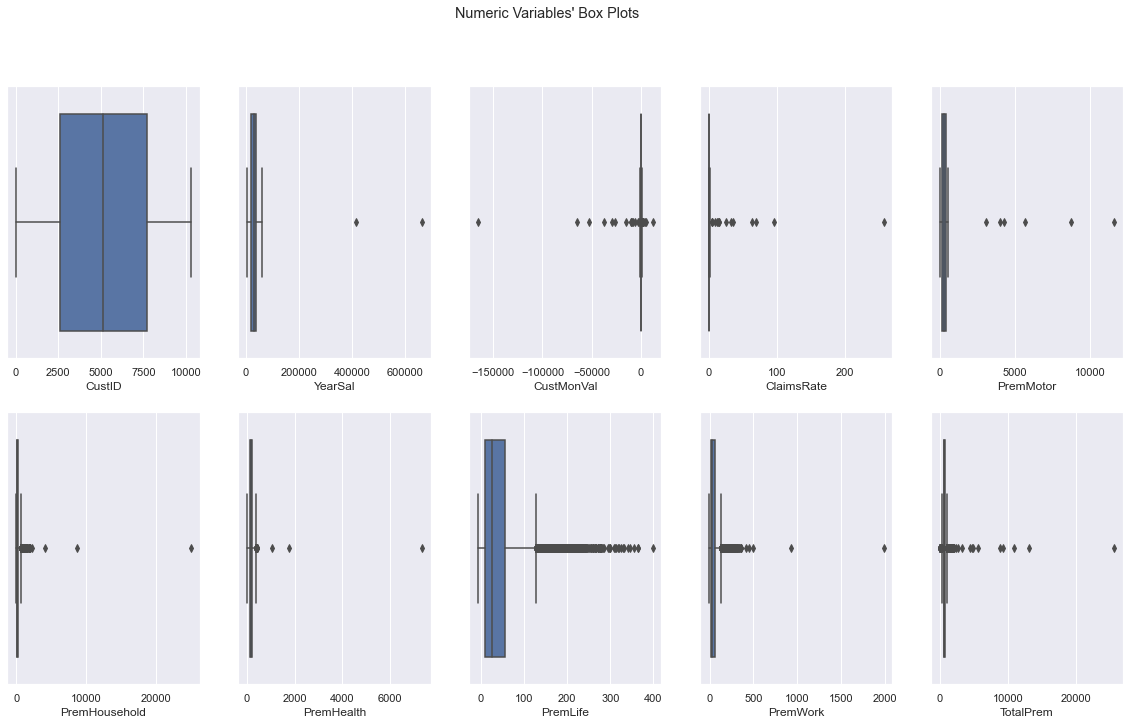

In [53]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(x=df[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

In [54]:
df_1=df.copy()

#### Yearly Salary: 

[Text(0.5, 0, '')]

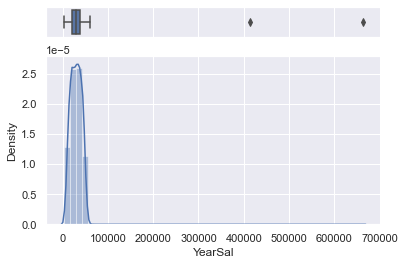

In [55]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df["YearSal"], ax=ax_box)
sns.distplot(df["YearSal"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [56]:
df_1 = df[df['YearSal']<=400000]

[Text(0.5, 0, '')]

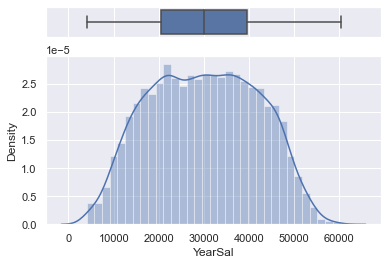

In [57]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df_1["YearSal"], ax=ax_box)
sns.distplot(df_1["YearSal"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

#### Customer Monetary Value: 

[Text(0.5, 0, '')]

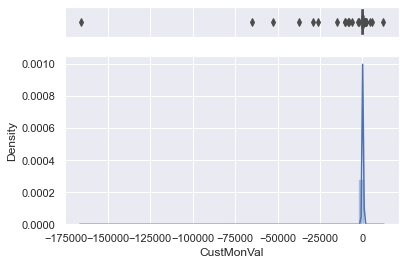

In [58]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df["CustMonVal"], ax=ax_box)
sns.distplot(df["CustMonVal"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [59]:
df_1 = df[df['CustMonVal']>=-2000]

[Text(0.5, 0, '')]

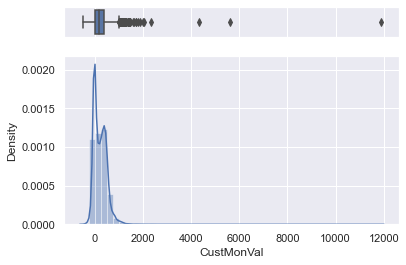

In [60]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df_1["CustMonVal"], ax=ax_box)
sns.distplot(df_1["CustMonVal"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [61]:
df_1 = df_1[df_1['CustMonVal']<=1500]

[Text(0.5, 0, '')]

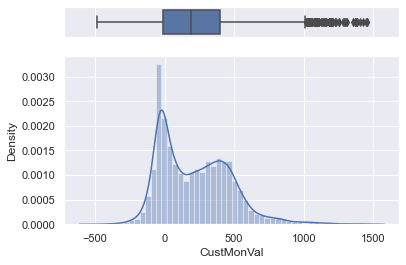

In [62]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df_1["CustMonVal"], ax=ax_box)
sns.distplot(df_1["CustMonVal"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

#### Claims Rate: 

[Text(0.5, 0, '')]

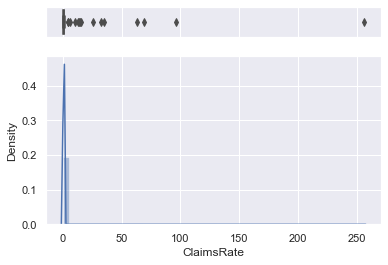

In [63]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df["ClaimsRate"], ax=ax_box)
sns.distplot(df["ClaimsRate"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [64]:
df_1 = df[df['ClaimsRate']<=100]

[Text(0.5, 0, '')]

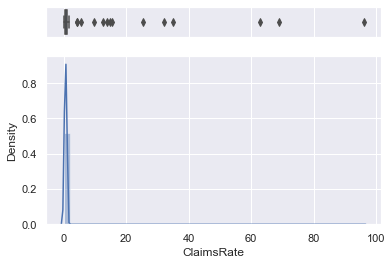

In [65]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df_1["ClaimsRate"], ax=ax_box)
sns.distplot(df_1["ClaimsRate"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [66]:
df_1 = df[df['ClaimsRate']<=4]

[Text(0.5, 0, '')]

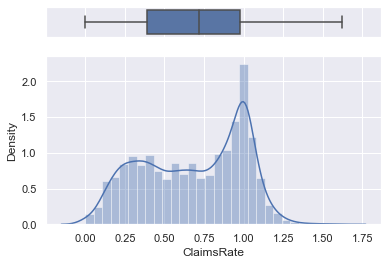

In [67]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df_1["ClaimsRate"], ax=ax_box)
sns.distplot(df_1["ClaimsRate"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

#### Premimum Motor: 

[Text(0.5, 0, '')]

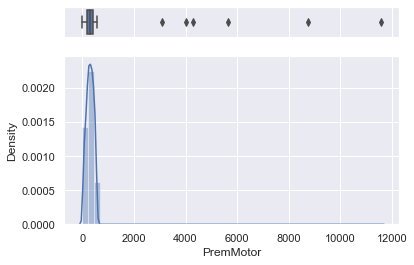

In [68]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df["PremMotor"], ax=ax_box)
sns.distplot(df["PremMotor"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [69]:
df_1 = df[df['PremMotor']<=3000]

[Text(0.5, 0, '')]

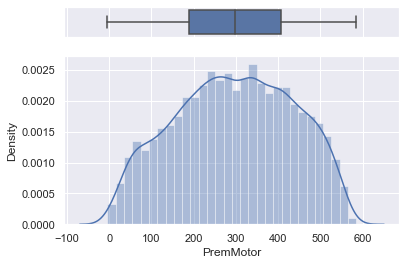

In [70]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df_1["PremMotor"], ax=ax_box)
sns.distplot(df_1["PremMotor"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

#### Premimum Household: 

[Text(0.5, 0, '')]

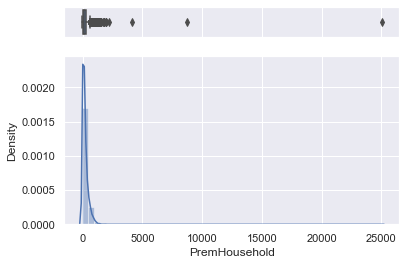

In [71]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df["PremHousehold"], ax=ax_box)
sns.distplot(df["PremHousehold"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [72]:
df_1 = df[df['PremHousehold']<=1600]

[Text(0.5, 0, '')]

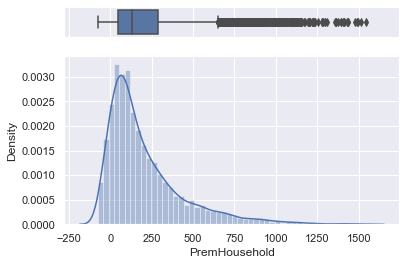

In [73]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df_1["PremHousehold"], ax=ax_box)
sns.distplot(df_1["PremHousehold"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

#### Premium Health: 

[Text(0.5, 0, '')]

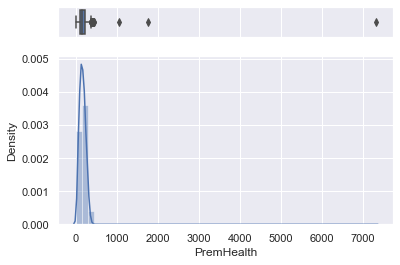

In [74]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df["PremHealth"], ax=ax_box)
sns.distplot(df["PremHealth"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [75]:
df_1 = df[df['PremHealth']<=1000]

[Text(0.5, 0, '')]

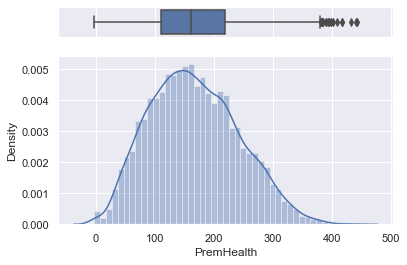

In [76]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df_1["PremHealth"], ax=ax_box)
sns.distplot(df_1["PremHealth"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

#### Premimum Work: 

[Text(0.5, 0, '')]

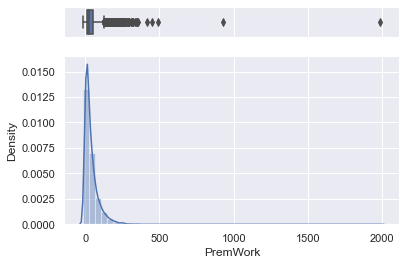

In [77]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df["PremWork"], ax=ax_box)
sns.distplot(df["PremWork"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [78]:
df_1 = df[df['PremWork']<=400]

[Text(0.5, 0, '')]

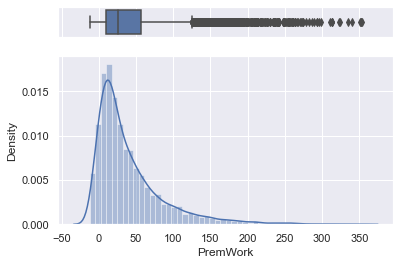

In [79]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df_1["PremWork"], ax=ax_box)
sns.distplot(df_1["PremWork"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

#### Total Premiums: 

[Text(0.5, 0, '')]

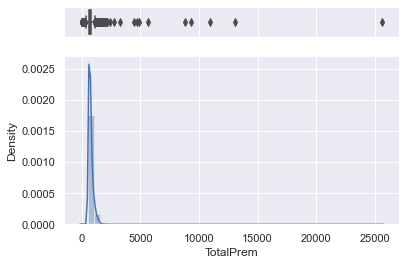

In [80]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df["TotalPrem"], ax=ax_box)
sns.distplot(df["TotalPrem"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [81]:
df_1 = df[df['TotalPrem']<=10000]

[Text(0.5, 0, '')]

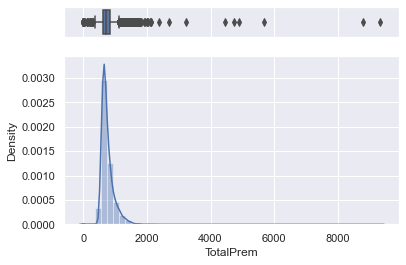

In [82]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df_1["TotalPrem"], ax=ax_box)
sns.distplot(df_1["TotalPrem"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [83]:
df_1 = df[df['TotalPrem']<=2300]

[Text(0.5, 0, '')]

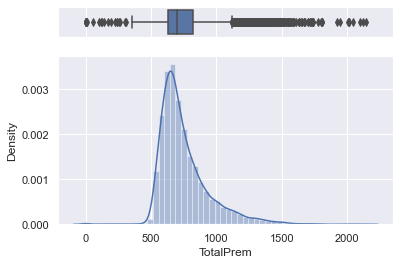

In [84]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df_1["TotalPrem"], ax=ax_box)
sns.distplot(df_1["TotalPrem"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [85]:
len(df.loc[df['TotalPrem']>2300])

12

In [86]:
#Final Filters: 
filters = (
    (df['YearSal']<=400000) #2
    &
    
    (df['ClaimsRate']<=4) #<100 1 #<4 12
    &
    (df['PremMotor']<=3000) #6
     &
    (df['PremHousehold']<=1600) #<2000 4  #<1600 12
    &
    (df['PremHealth']<=5000) #<5000 2 # <1000 3
    &
    (df['PremLife']<=370) #1
    
    &
    (df['PremWork']<=400) #5
    
     &
    (df['TotalPrem']<=2300) #<10000 3 #<2300 12
)

df_1 = df[filters]
print('Percentage of data kept after removing outliers:', np.round(df_1.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing outliers: 0.9928


In [87]:
df_1.describe()

CustID  FirstPolYear       YearSal    GeoLivArea      Children  \
count  10222.000000  10222.000000  10222.000000  10222.000000  10222.000000   
mean    5150.505185   1986.014283  29990.115983      2.711113      0.707494   
std     2970.316921      6.607846  11785.083957      1.266547      0.454936   
min        1.000000   1974.000000   3996.000000      1.000000      0.000000   
25%     2580.250000   1980.000000  20520.000000      1.000000      0.000000   
50%     5147.500000   1986.000000  30048.000000      3.000000      1.000000   
75%     7720.750000   1992.000000  39468.000000      4.000000      1.000000   
max    10296.000000   1998.000000  60252.000000      4.000000      1.000000   

         CustMonVal    ClaimsRate     PremMotor  PremHousehold    PremHealth  \
count  10222.000000  10222.000000  10222.000000   10222.000000  10222.000000   
mean     217.291104      0.680197    296.230976     205.514288    167.367363   
std      255.394646      0.318690    138.644096     231.064274     74.722573   
min     -490.200000      0.000000     -4.110000     -75.000000     -2.110000   
25%       -9.107500      0.390000    190.370000      49.450000    111.020000   
50%      187.090000      0.720000    298.390000     132.800000    162.420000   
75%      398.625000      0.980000    407.410000     290.050000    218.930000   
max     1571.760000      1.620000    585.220000    1544.750000    442.860000   

           PremLife      PremWork     TotalPrem  
count  10222.000000  10222.000000  10222.000000  
mean      41.406210     40.505002    751.023839  
std       47.339779     46.337927    190.516486  
min       -7.000000    -12.000000      0.000000  
25%        9.890000      9.890000    626.450000  
50%       25.450000     25.560000    697.245000  
75%       57.010000     55.900000    823.130000  
max      365.180000    353.180000   1809.690000

### After Outlier Removal: 

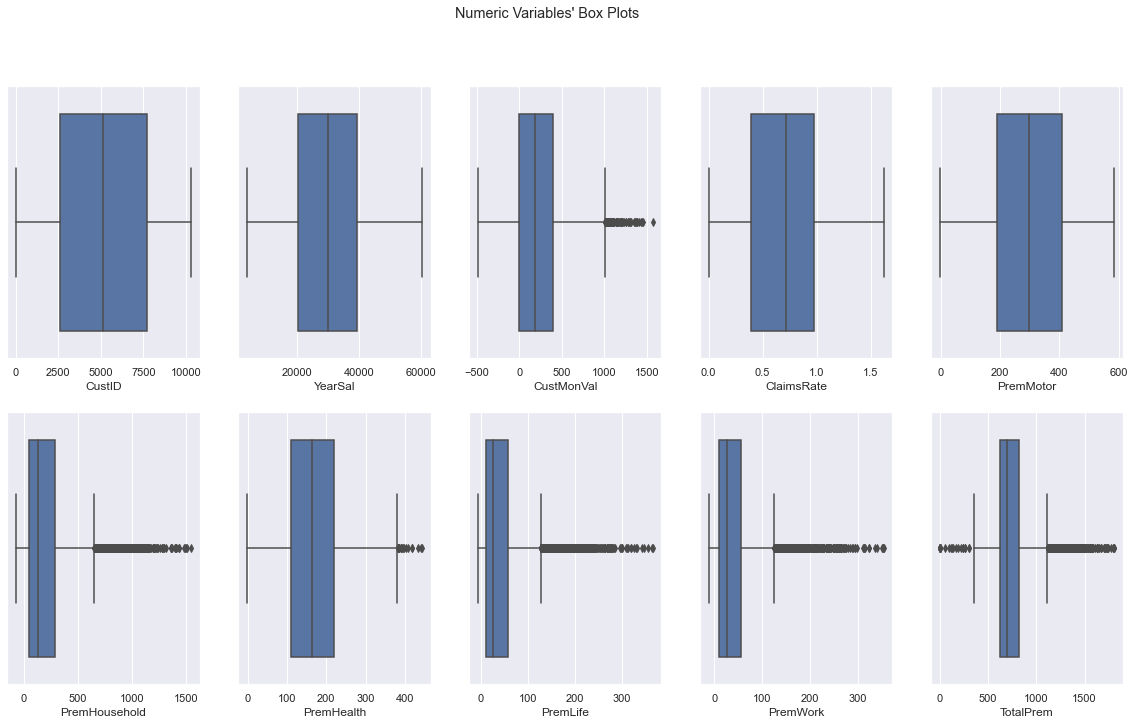

In [88]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(x=df_1[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

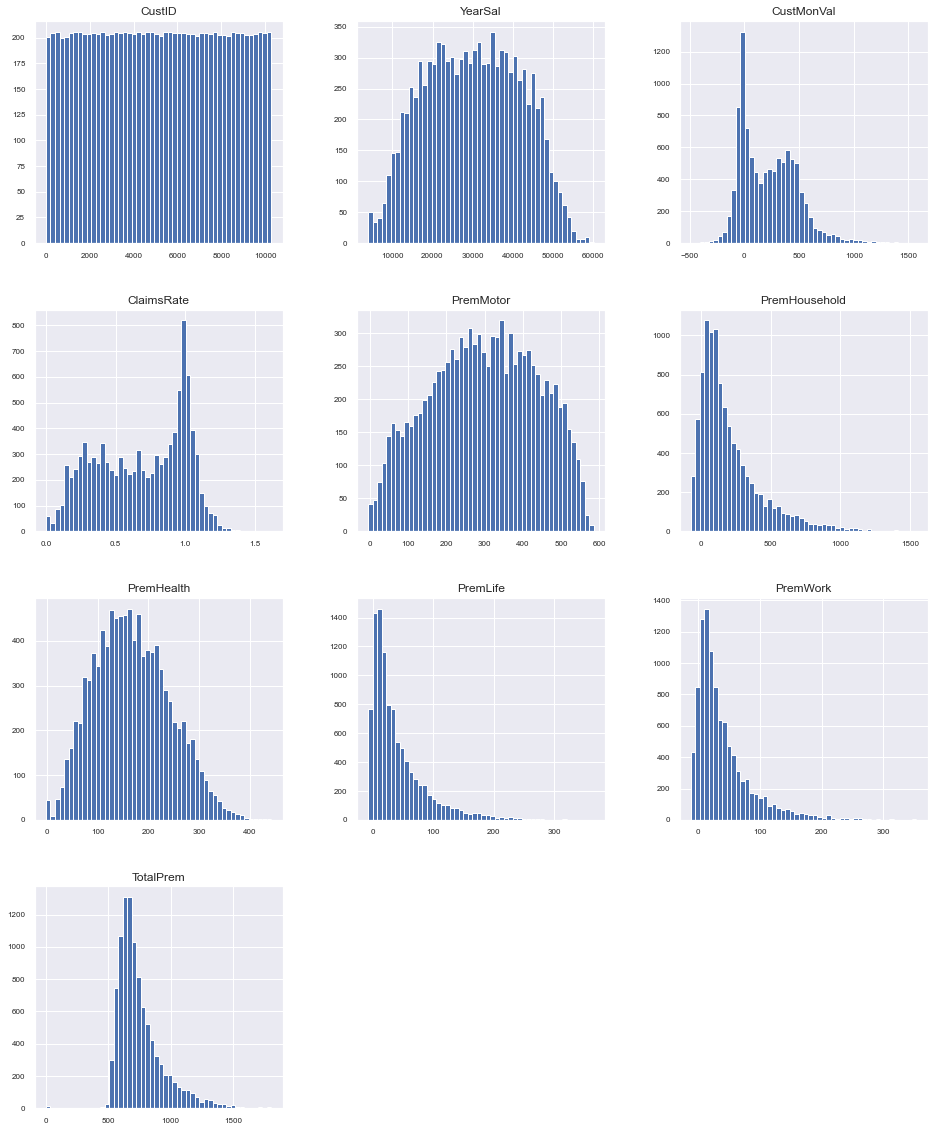

In [89]:
df_1[metric_features].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [90]:
df = df[filters]

In [91]:
df=df.reset_index()
df=df.drop(['index'], axis=1)

## Variable selection: Redundancy VS Relevancy

### Redundancy:

#### Correlation 

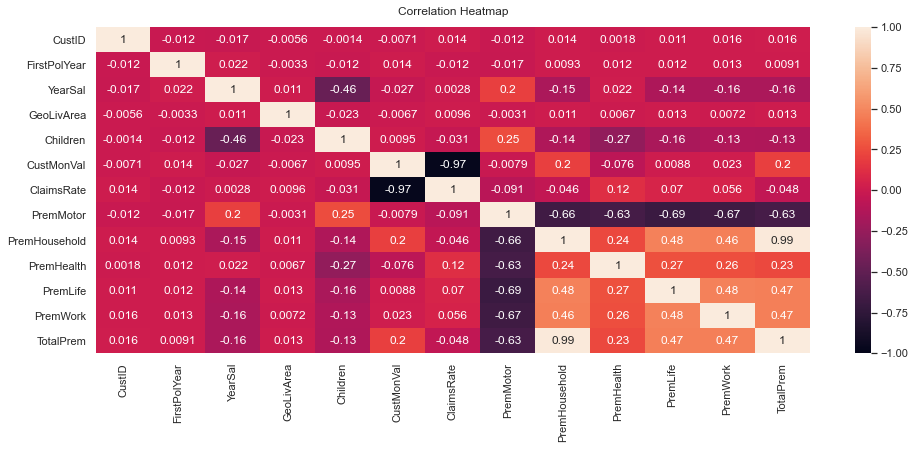

In [92]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(method='spearman'), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

- CustMonVal or claimsRate
- Premium Household or TotalPrem

### Relevancy

#### Grouped Boxplots

In [93]:
def grouped_boxplot(non_met_feat):

    # All Numeric Variables' Box Plots in one figure, to be plotted against a non metric feature 
    sns.set()

    # Prepare figure. Create individual axes where each box plot will be placed
    fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

    # Plot data
    # Iterate across axes objects and associate each box plot (hint: use the ax argument):
    for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
        sns.boxplot(x = df[non_met_feat], y = df[feat], ax=ax)

    title = "Numeric Variables' Box Plots"
    plt.suptitle(title)
    plt.show()

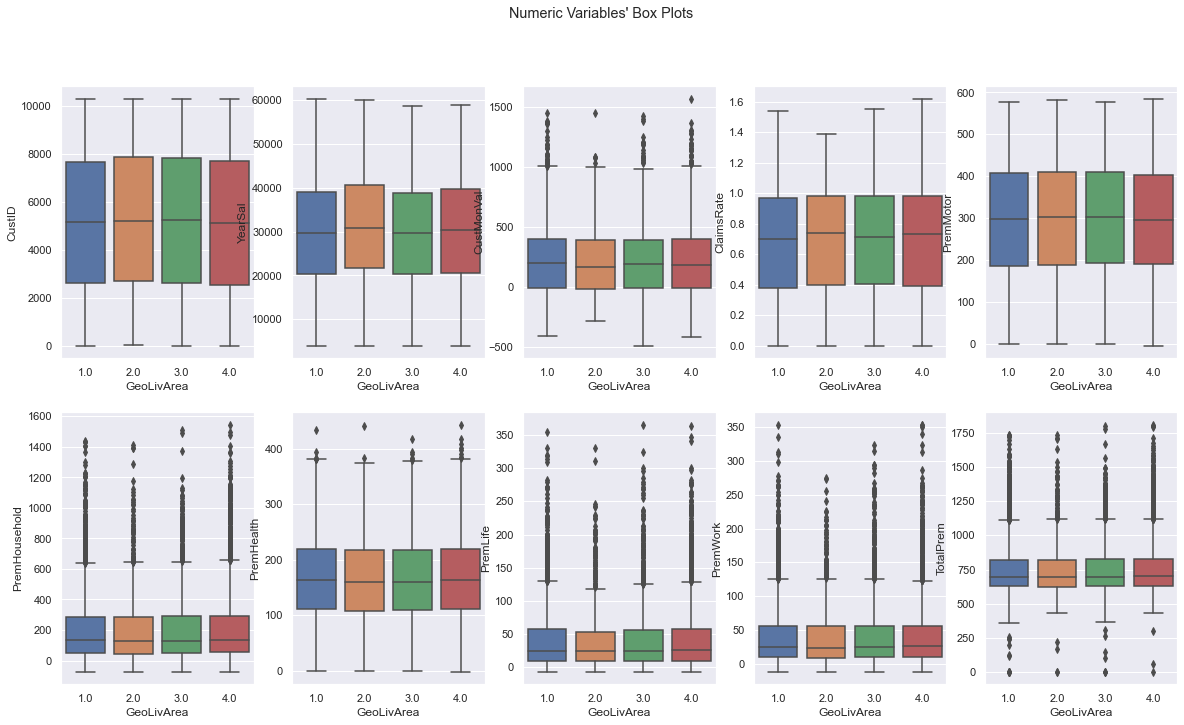

In [94]:
grouped_boxplot("GeoLivArea")

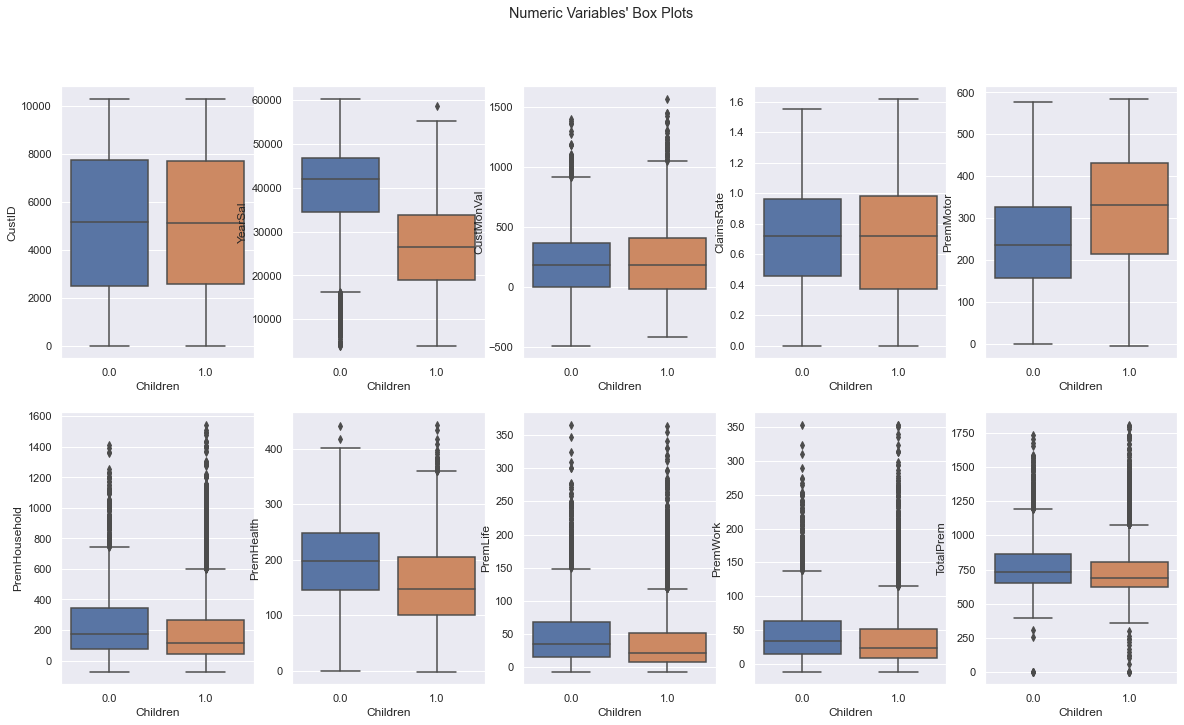

In [95]:
grouped_boxplot("Children")

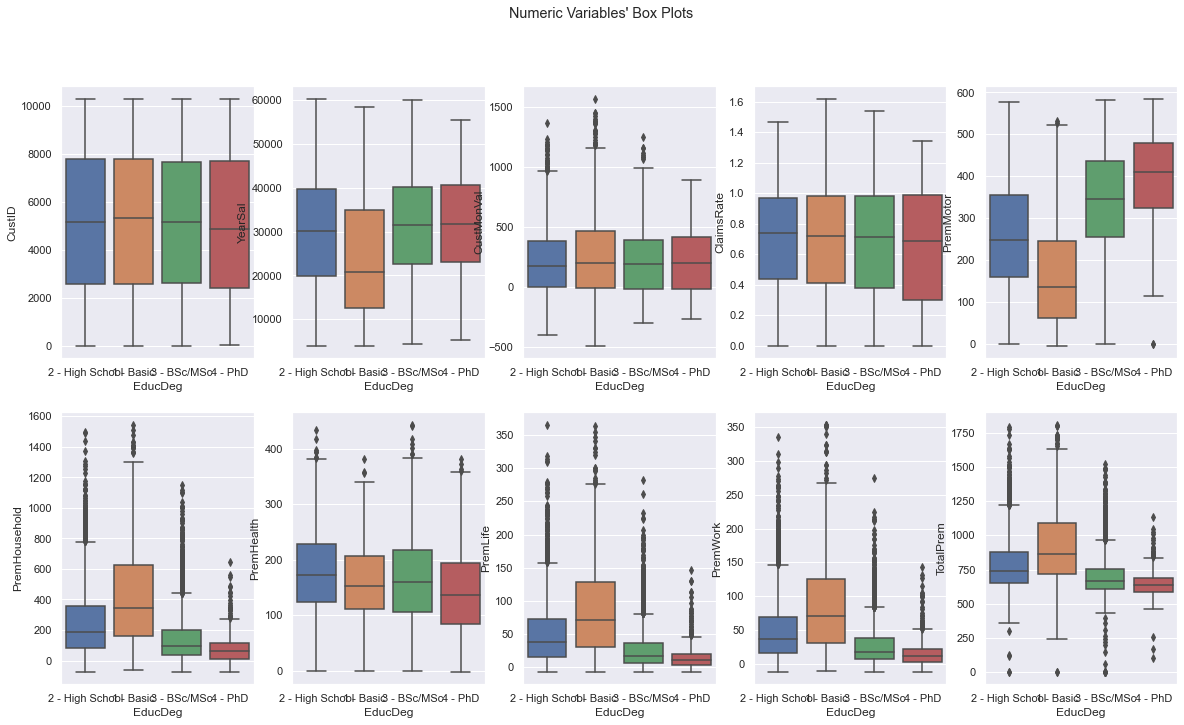

In [96]:
grouped_boxplot("EducDeg")

#### Variance Threshold

In [97]:
df.var()

CustID           8.822783e+06
FirstPolYear     4.366363e+01
YearSal          1.388882e+08
GeoLivArea       1.604140e+00
Children         2.069666e-01
CustMonVal       6.522643e+04
ClaimsRate       1.015635e-01
PremMotor        1.922219e+04
PremHousehold    5.339070e+04
PremHealth       5.583463e+03
PremLife         2.241055e+03
PremWork         2.147203e+03
TotalPrem        3.629653e+04
dtype: float64

#### Applying square root

In [98]:
df_sqrt_ = df.copy()
df_sqrt_[metric_features] = df_sqrt_[metric_features].apply(lambda x: np.sign(x)*np.sqrt(abs(x)) if np.issubdtype(x.dtype, np.number) else x)

#### Applying MinMaxScaler

In [99]:
df_minmax=df_sqrt_.copy()

minmax = MinMaxScaler()
minmax_feat = minmax.fit_transform(df_minmax[metric_features])
df_minmax[metric_features] = minmax_feat

df_minmax.var()

CustID            0.056506
FirstPolYear     43.663625
YearSal           0.039109
GeoLivArea        1.604140
Children          0.206967
CustMonVal        0.037916
ClaimsRate        0.029803
PremMotor         0.030084
PremHousehold     0.032905
PremHealth        0.018836
PremLife          0.027262
PremWork          0.027983
TotalPrem         0.006246
dtype: float64

In [100]:
vt = VarianceThreshold(threshold=.03)

# Fit
_ = vt.fit(df_minmax[metric_features])

# Get the mask
mask = vt.get_support()

# Subset the DataFrame
df_vt_final = df[metric_features].loc[:, mask]

In [101]:
df_vt_final.columns

Index(['CustID', 'YearSal', 'CustMonVal', 'PremMotor', 'PremHousehold'], dtype='object')

Although we are not going to use CustMonVal, TotalPrem, GeoLivArea in the clustering process, they will be kept in the dataset to be used later on in the profiling step. 

In [102]:
df=df.drop(['CustID'], axis=1)

In [103]:
df.shape

(10222, 13)

## Feature Engineering

In [104]:
df['Customer_lifetime']=2016 - df['FirstPolYear']

In [105]:
df=df.drop(['FirstPolYear'], axis=1)

## One-hot encoding

In [106]:
df['EducDeg']=df['EducDeg'].str.slice(stop=1)
df['EducDeg']=pd.to_numeric(df['EducDeg'])

## Data Normalization

In [107]:
non_metric_features = ["EducDeg", "GeoLivArea","Children"]
metric_features = df.columns.drop(non_metric_features).to_list()

In [108]:
#Apply square root transformation
df_sqrt=df.copy()
df_sqrt[metric_features] = df_sqrt[metric_features].apply(lambda x: np.sign(x)*np.sqrt(abs(x)) if np.issubdtype(x.dtype, np.number) else x)
df_sqrt

EducDeg     YearSal  GeoLivArea  Children  CustMonVal  ClaimsRate  \
0            2  161.629205         1.0       1.0   19.518453    0.624500   
1            2   90.133235         4.0       1.0  -11.451201    1.058301   
2            1  165.299728         3.0       0.0   22.464861    0.529150   
3            3  114.839018         4.0       1.0   -4.121893    0.994987   
4            3  145.451023         4.0       1.0    5.935487    0.948683   
...        ...         ...         ...       ...         ...         ...   
10217        4  195.591411         2.0       0.0   -0.331662    0.979796   
10218        1  170.798126         3.0       0.0   37.491332    0.000000   
10219        3  187.125626         1.0       1.0   22.893230    0.458258   
10220        1  153.792067         2.0       1.0   15.812969    0.806226   
10221        4  183.793362         1.0       1.0   21.534855    0.519615   

       PremMotor  PremHousehold  PremHealth   PremLife   PremWork  TotalPrem  \
0      19.386851       8.913473   12.097934   6.856384   4.109745  25.798450   
1       8.801136      20.400980   10.802315  13.945609  10.301942  30.182114   
2      14.357925      14.983324   11.161541   9.292470   9.950879  27.213967   
3      13.508516       6.584072   17.640011   5.944746   5.323533  24.508774   
4      18.401630       6.913754   13.512587   4.333590   6.438167  25.084657   
...          ...            ...         ...        ...        ...        ...   
10217  19.842883       7.032069   13.183702   3.127299   3.844477  25.329035   
10218  11.557681      32.183070   11.968709   3.590265  10.253292  37.823273   
10219  20.090545      11.523888   11.926860   3.559494   2.211334  26.386360   
10220  13.732807      14.531001   14.084389   7.993748  10.625912  27.837385   
10221  20.348956       9.718539   11.884864   2.624881   3.590265  25.875857   

       Customer_lifetime  
0               5.567764  
1               5.916080  
2               5.000000  
3               5.099020  
4               5.477226  
...                  ...  
10217           5.656854  
10218           6.244998  
10219           4.690416  
10220           5.916080  
10221           5.099020  

[10222 rows x 13 columns]

In [109]:
#Apply standard scaler:
df_scaled=df_sqrt.copy()

In [110]:
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(df_scaled[metric_features])
scaled_feat

array([[-0.21519773,  0.77395263, -0.77569683, ..., -0.30354015,
        -0.4162596 ,  0.20636239],
       [-2.19900051, -1.80032468,  1.19865538, ...,  1.35967015,
         0.88770222,  0.77693638],
       [-0.11335153,  1.0188657 , -1.20966008, ...,  1.26537563,
         0.00479926, -0.72368996],
       ...,
       [ 0.49225292,  1.05447283, -1.53231317, ..., -0.81344886,
        -0.24138013, -1.23081858],
       [-0.43265524,  0.46594331,  0.05139049, ...,  1.44668781,
         0.19024073,  0.77693638],
       [ 0.3997924 ,  0.94156121, -1.2530567 , ..., -0.44307129,
        -0.39323389, -0.56148653]])

In [111]:
df_scaled[metric_features] = scaled_feat
df_scaled.head()

EducDeg   YearSal  GeoLivArea  Children  CustMonVal  ClaimsRate  PremMotor  \
0        2 -0.215198         1.0       1.0    0.773953   -0.775697   0.612898   
1        2 -2.199001         4.0       1.0   -1.800325    1.198655  -1.715005   
2        1 -0.113352         3.0       0.0    1.018866   -1.209660  -0.493012   
3        3 -1.513488         4.0       1.0   -1.191094    0.910499  -0.679806   
4        3 -0.664095         4.0       1.0   -0.355098    0.699756   0.396238   

   PremHousehold  PremHealth  PremLife  PremWork  TotalPrem  Customer_lifetime  
0      -0.315696   -0.150714  0.412395 -0.303540  -0.416260           0.206362  
1       1.004702   -0.570355  2.386076  1.359670   0.887702           0.776936  
2       0.381985   -0.454004  1.090615  1.265376   0.004799          -0.723690  
3      -0.583443    1.644320  0.158590  0.022481  -0.799886          -0.561487  
4      -0.545548    0.307480 -0.289965  0.321869  -0.628584           0.058051

### Final variables used in clustering: 

In [112]:
metric_features=['YearSal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork','Customer_lifetime']

## Redo data exploration

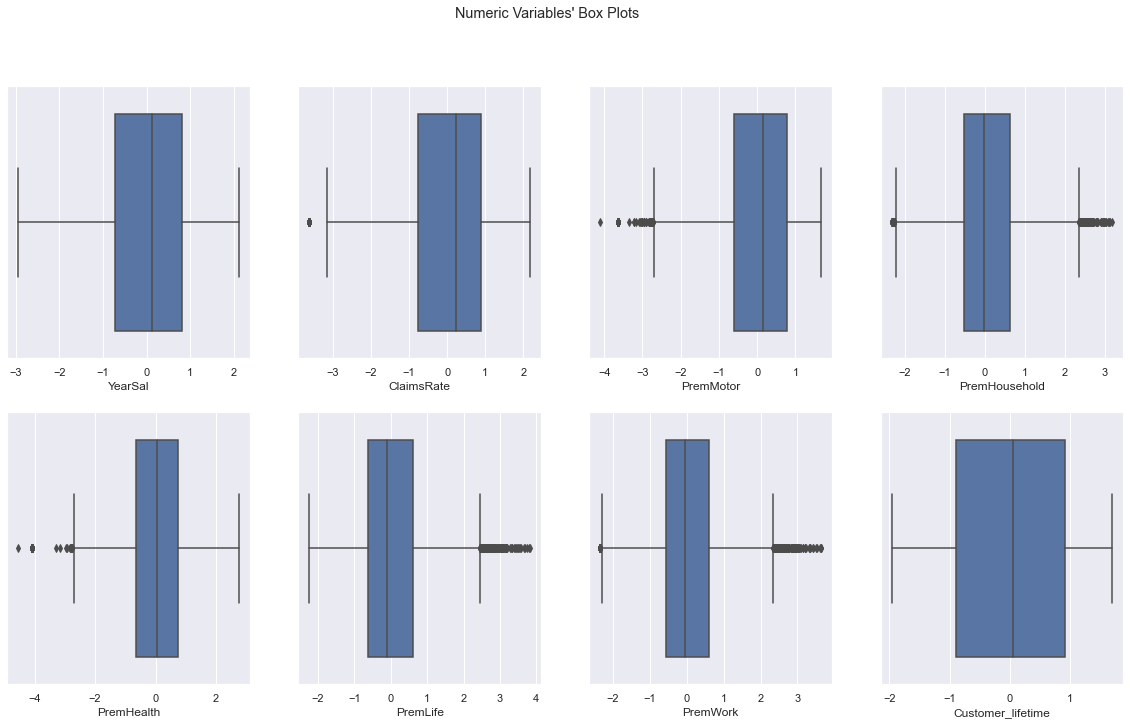

In [113]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(x=df_scaled[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

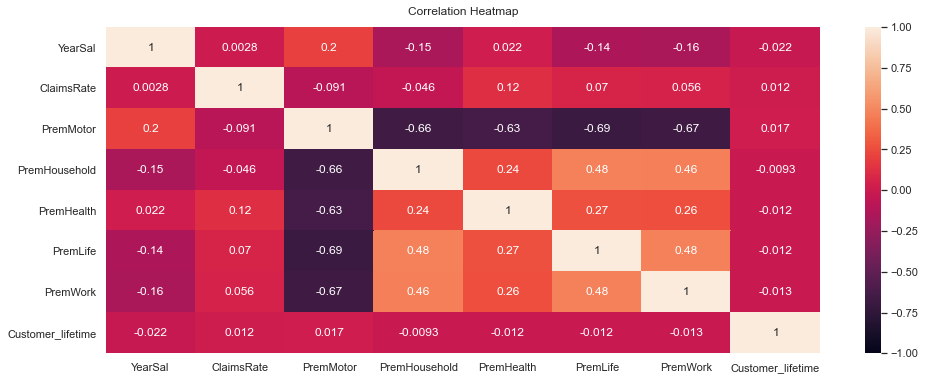

In [114]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df_scaled[metric_features].corr(method='spearman'), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## Clustering:

### Hierarchical Clustering

#### Defining the linkage method to choose:

In [115]:
# Performing HC
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=5)
hc_labels = hclust.fit_predict(df_scaled[metric_features])
hc_labels

array([4, 2, 0, ..., 1, 0, 1], dtype=int64)

In [116]:
# Characterizing the clusters
df_concat = pd.concat((df_scaled[metric_features], pd.Series(hc_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

YearSal  ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  \
labels                                                                         
0       0.659656    0.175379  -0.149024       0.184605    0.320871  0.241423   
1       0.068132   -1.324882   0.866791      -0.733460   -0.722608 -0.726616   
2      -1.575234    0.112954  -1.784492       1.164234    0.020163  1.407146   
3       0.142265    0.932635   1.090783      -0.933544   -1.025813 -0.857273   
4      -0.788354    0.201440  -0.292635       0.314166    0.693568 -0.009407   

        PremWork  Customer_lifetime  
labels                               
0       0.150349          -0.048222  
1      -0.691722          -0.145845  
2       1.285414           0.000483  
3      -0.875681           0.157276  
4       0.242849           0.143755

In [117]:
# Computing SST
X = df_scaled[metric_features].values
sst = np.sum(np.square(X - X.mean(axis=0)), axis=0)

# Computing SSW
ssw_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssw_iter.append(np.sum(np.square(X_k - X_k.mean(axis=0)), axis=0))
ssw = np.sum(ssw_iter, axis=0)

# Computing SSB
ssb_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssb_iter.append(X_k.shape[0] * np.square(X_k.mean(axis=0) - X.mean(axis=0)))
ssb = np.sum(ssb_iter, axis=0)

# Verifying the formula
np.round(sst) == np.round((ssw + ssb))

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [118]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss  # return sum of sum of squares of each df variable
    
    sst = get_ss(df)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        
        
        hclabels = cluster.fit_predict(df) #get cluster labels
        
        
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  # concat df with labels
        
        
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
        
        
        ssb = sst - np.sum(ssw_labels)  
        
        
        r2.append(ssb / sst)  # save the R2 of the given cluster solution
        
    return np.array(r2)

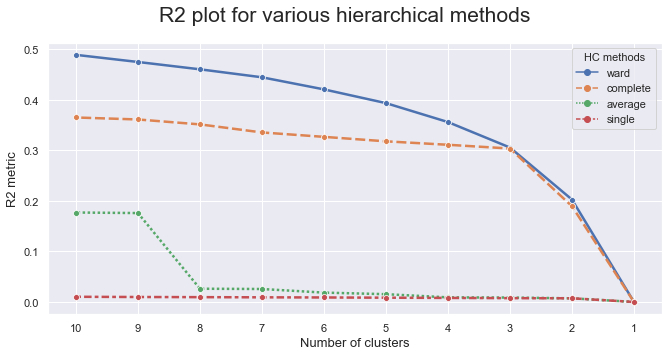

In [119]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack(
    [
        get_r2_hc(df=df_scaled[metric_features], link_method=link, max_nclus=max_nclus) 
        for link in hc_methods
    ]
).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

### Defining the number of clusters:

In [120]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df_scaled[metric_features])

array([6016, 6110, 9497, ...,    5,    2,    0], dtype=int64)

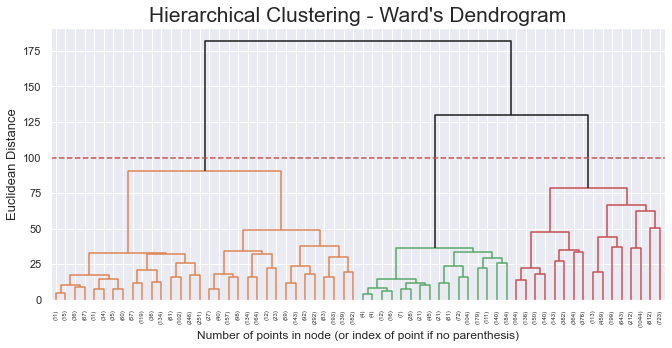

In [121]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 100
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

### Final Hierarchical clustering solution

In [122]:
# 3 cluster solution
linkage = 'ward'
distance = 'euclidean'
hc3lust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=3)
hc3_labels = hc3lust.fit_predict(df_scaled[metric_features])

In [123]:
# Characterizing the 3 clusters
df_concat = pd.concat((df_scaled[metric_features], pd.Series(hc3_labels, name='labels')), axis=1)
hc=df_concat.groupby('labels').mean()
hc['Labels_2'] = hc.index 
hc

YearSal  ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  \
labels                                                                         
0       0.098774   -0.391756   0.959376      -0.816163   -0.847935 -0.780622   
1       0.216412    0.183357  -0.192984       0.224264    0.434956  0.164643   
2      -1.575234    0.112954  -1.784492       1.164234    0.020163  1.407146   

        PremWork  Customer_lifetime  Labels_2  
labels                                         
0      -0.767760          -0.020552         0  
1       0.178664           0.010543         1  
2       1.285414           0.000483         2

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'YearSal'),
  Text(1, 0, 'ClaimsRate'),
  Text(2, 0, 'PremMotor'),
  Text(3, 0, 'PremHousehold'),
  Text(4, 0, 'PremHealth'),
  Text(5, 0, 'PremLife'),
  Text(6, 0, 'PremWork'),
  Text(7, 0, 'Customer_lifetime')])

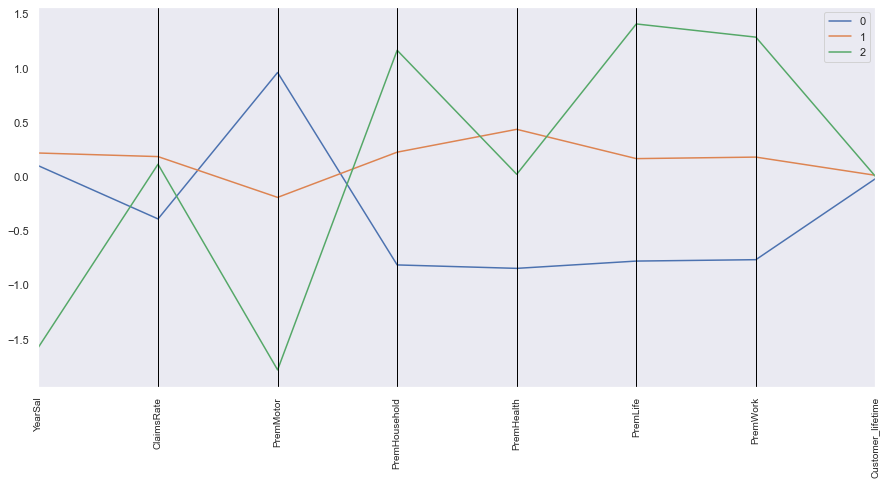

In [124]:
plt.figure(figsize=(15, 7))
pd.plotting.parallel_coordinates(hc, class_column='Labels_2', color=sns.color_palette())
plt.xticks(fontsize=10, rotation=90)

In [125]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_concat[metric_features])  # get total sum of squares
ssw_labels = df_concat[metric_features + ["labels"]].groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  
r2 = ssb / sst
r2

0.30560028135311135

### Kmeans Clustering


In [126]:
metric_features

['YearSal',
 'ClaimsRate',
 'PremMotor',
 'PremHousehold',
 'PremHealth',
 'PremLife',
 'PremWork',
 'Customer_lifetime']

#### Defining the number of clusters:

**The Elbow Method**

In [127]:
range_clusters = range(1, 15)
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_scaled[metric_features])
    inertia.append(kmclust.inertia_)

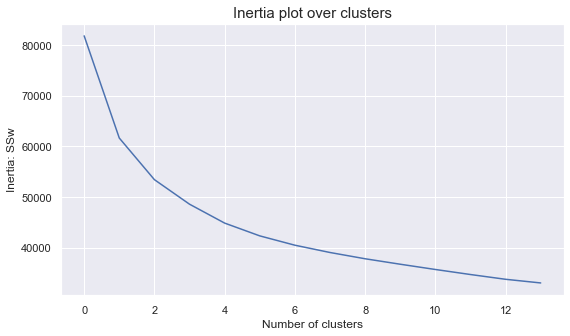

In [128]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
ax.set_xlim(1, 24)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

**The Silhouette Method**

For n_clusters = 2, the average silhouette_score is : 0.21061883771308365
For n_clusters = 3, the average silhouette_score is : 0.17493120275881222
For n_clusters = 4, the average silhouette_score is : 0.1730608964932325
For n_clusters = 5, the average silhouette_score is : 0.16309076131692185
For n_clusters = 6, the average silhouette_score is : 0.1615547732754705
For n_clusters = 7, the average silhouette_score is : 0.14648648438298562
For n_clusters = 8, the average silhouette_score is : 0.14247712043844865
For n_clusters = 9, the average silhouette_score is : 0.13326019724453492
For n_clusters = 10, the average silhouette_score is : 0.13297455712621167
For n_clusters = 11, the average silhouette_score is : 0.13206132542046709
For n_clusters = 12, the average silhouette_score is : 0.13187934930946985
For n_clusters = 13, the average silhouette_score is : 0.13152937248630953
For n_clusters = 14, the average silhouette_score is : 0.13008727263919095


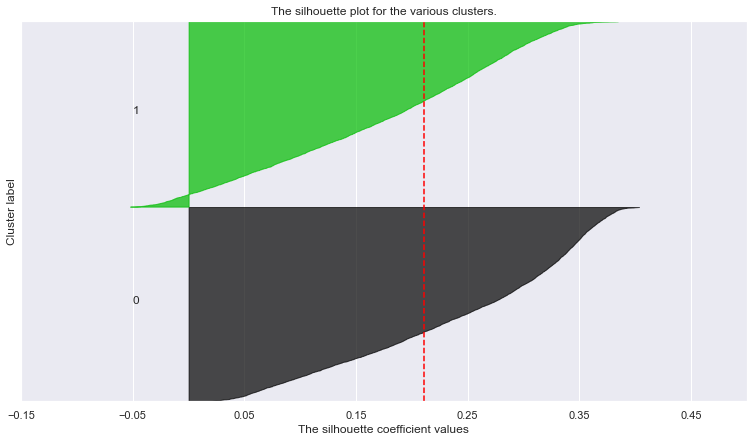

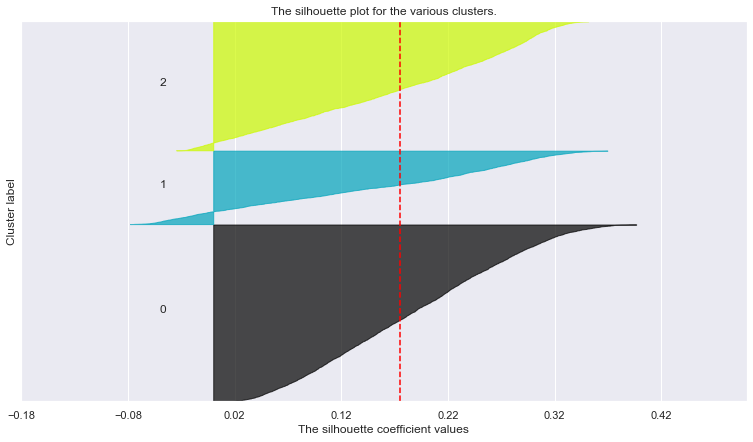

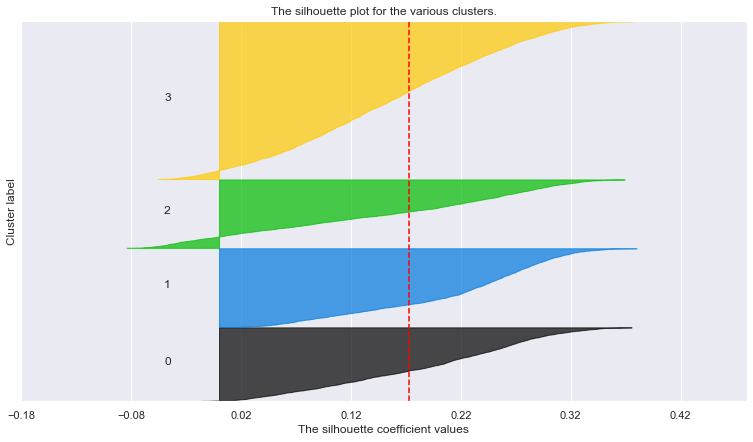

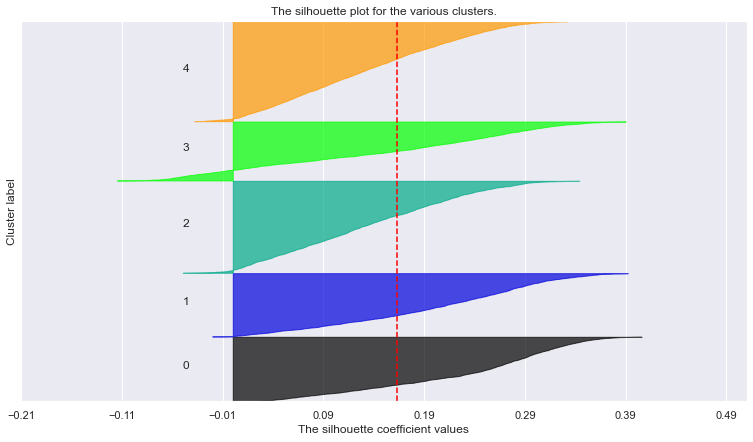

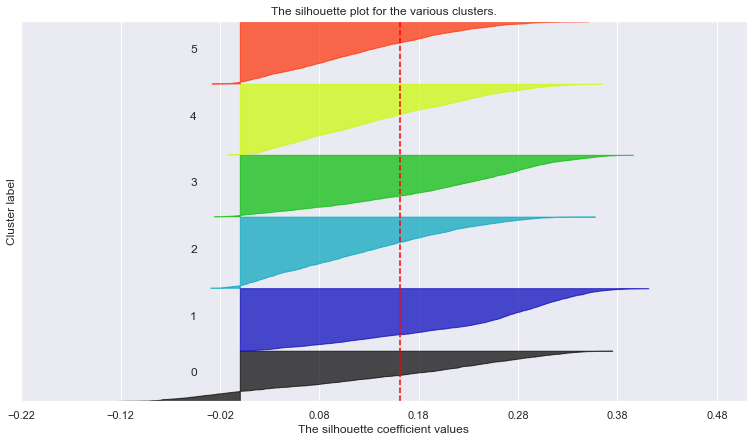

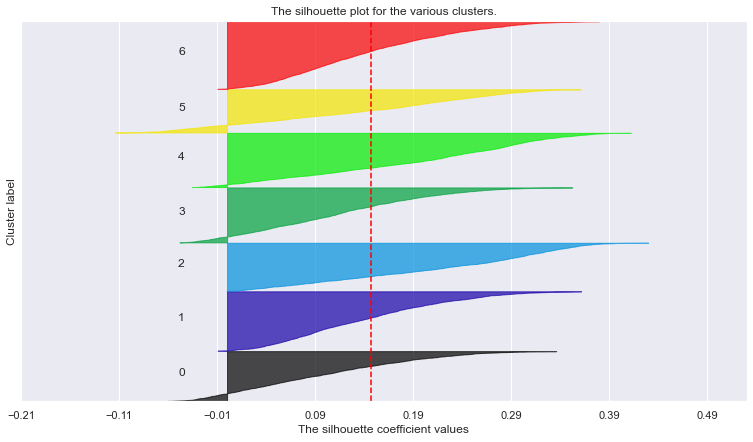

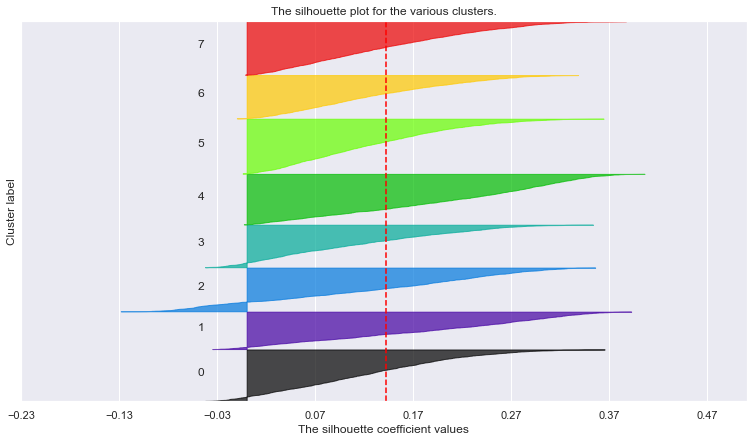

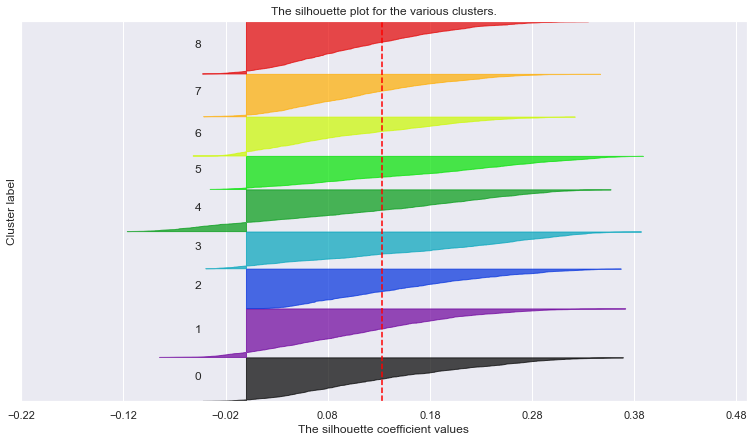

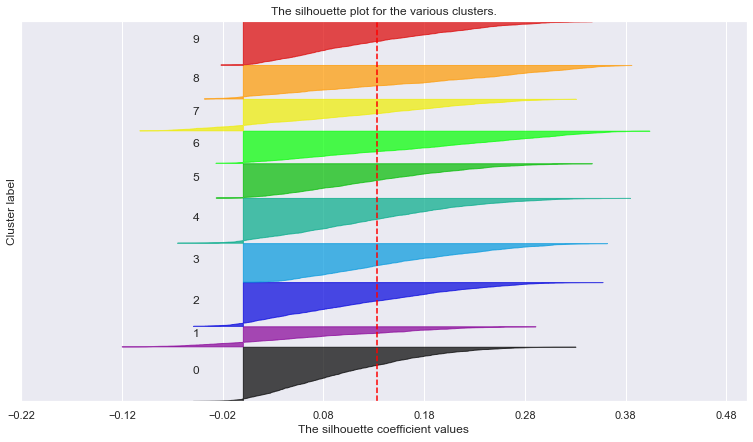

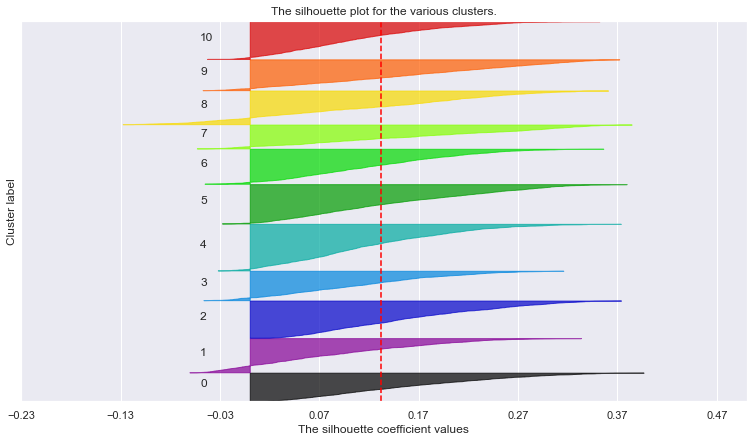

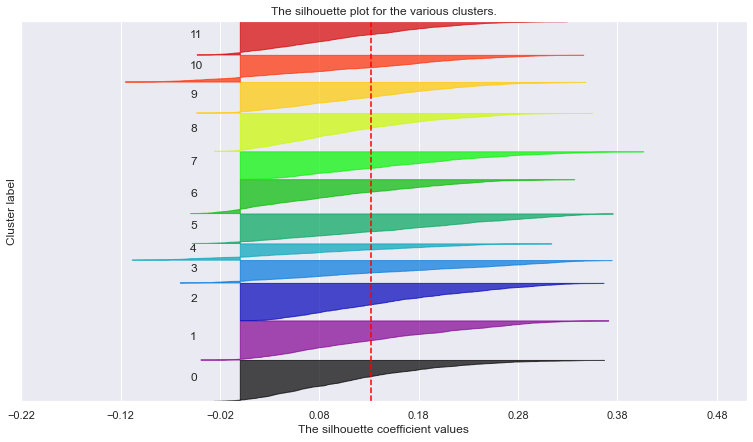

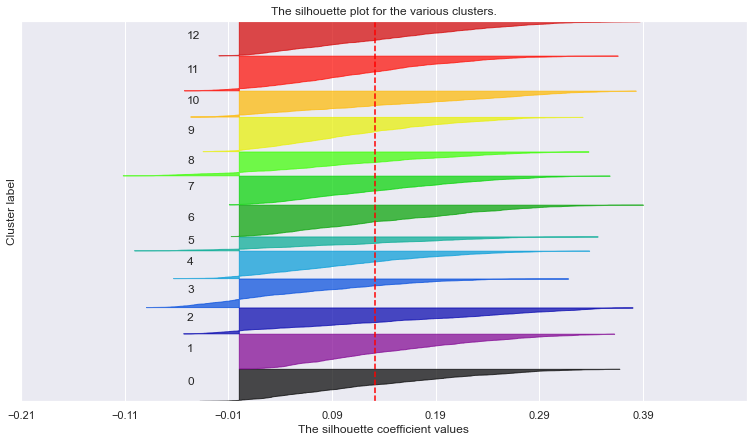

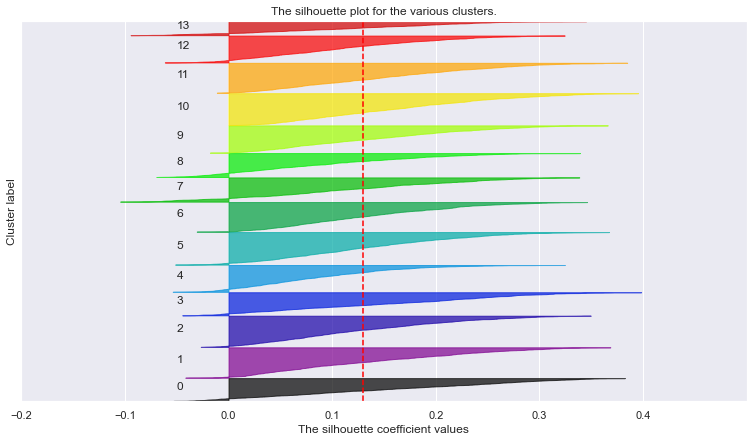

In [129]:
# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df_scaled[metric_features])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_scaled[metric_features], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_scaled[metric_features], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df_scaled[metric_features]) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

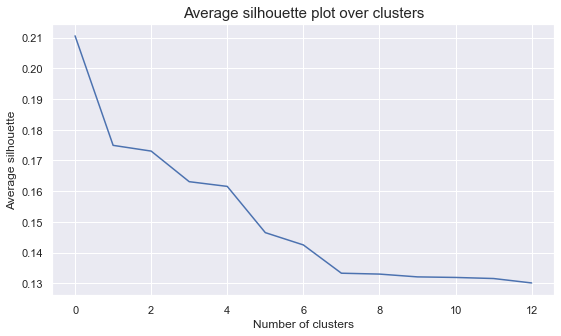

In [130]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(avg_silhouette)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

### Final KMeans clustering solution

In [131]:
# final cluster solution
number_clusters = 3
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df_scaled[metric_features])
km_labels

array([2, 1, 1, ..., 2, 1, 2])

In [132]:
# Characterizing the final clusters
df_concat = pd.concat((df_scaled[metric_features], pd.Series(km_labels, name='labels')), axis=1)
km=df_concat.groupby('labels').mean()
km['Labels_2'] = km.index 
km

YearSal  ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  \
labels                                                                         
0       0.409610    0.214279  -0.143514       0.122884    0.554886  0.095565   
1      -1.189613    0.049725  -1.364158       1.032771    0.171022  1.120609   
2       0.116970   -0.321155   0.972252      -0.755521   -0.855686 -0.768157   

        PremWork  Customer_lifetime  Labels_2  
labels                                         
0       0.125207           0.001547         0  
1       1.039386          -0.023278         1  
2      -0.762460           0.011129         2

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'YearSal'),
  Text(1, 0, 'ClaimsRate'),
  Text(2, 0, 'PremMotor'),
  Text(3, 0, 'PremHousehold'),
  Text(4, 0, 'PremHealth'),
  Text(5, 0, 'PremLife'),
  Text(6, 0, 'PremWork'),
  Text(7, 0, 'Customer_lifetime')])

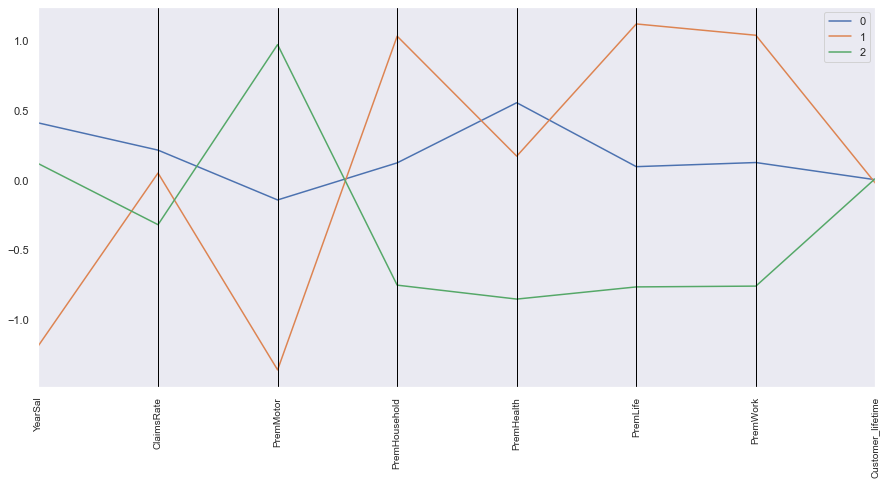

In [133]:
plt.figure(figsize=(15, 7))
pd.plotting.parallel_coordinates(km, class_column='Labels_2', color=sns.color_palette())
plt.xticks(fontsize=10, rotation=90)

In [134]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_concat[metric_features])  # get total sum of squares
ssw_labels = df_concat[metric_features + ["labels"]].groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  
r2 = ssb / sst
r2

0.34703879388015735

### Self-organizing Maps: 

In [135]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

sm = sompy.SOMFactory().build(
    df_scaled[metric_features].values, 
    mapsize=[50, 50], 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=metric_features
)
sm.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.004000 seconds
 Rough training...
 radius_ini: 17.000000 , radius_final: 2.833333, trainlen: 100

 epoch: 1 ---> elapsed time:  0.610000, quantization error: 1.719914

 epoch: 2 ---> elapsed time:  0.543000, quantization error: 2.682493

 epoch: 3 ---> elapsed time:  0.625000, quantization error: 2.651873

 epoch: 4 ---> elapsed time:  0.641000, quantization error: 2.636612

 epoch: 5 ---> elapsed time:  0.610000, quantization error: 2.632892

 epoch: 6 ---> elapsed time:  0.642000, quantization error: 2.631189

 epoch: 7 ---> elapsed time:  0.624000, quantization error: 2.629976

 epoch: 8 ---> elapsed time:  0.601000, quantization error: 2.628230

 epoch: 9 ---> elapsed time:  0.707000, quantization error: 2.624028

 epoch: 10 ---> elapsed time:  0.842000, quantization error: 2.617869

 epoch: 11 ---> elapsed time:  0.722000, quantization error: 2.612031

 epoch: 12 ---> elapsed time:  0.690000, quantization error: 2.610079

 epoch: 13 --->

 epoch: 14 ---> elapsed time:  0.625000, quantization error: 2.027231

 epoch: 15 ---> elapsed time:  0.615000, quantization error: 2.021306

 epoch: 16 ---> elapsed time:  0.625000, quantization error: 2.015321

 epoch: 17 ---> elapsed time:  0.603000, quantization error: 2.009332

 epoch: 18 ---> elapsed time:  0.612000, quantization error: 2.003198

 epoch: 19 ---> elapsed time:  0.585000, quantization error: 1.996973

 epoch: 20 ---> elapsed time:  0.577000, quantization error: 1.990646

 epoch: 21 ---> elapsed time:  0.591000, quantization error: 1.984296

 epoch: 22 ---> elapsed time:  0.568000, quantization error: 1.977820

 epoch: 23 ---> elapsed time:  0.576000, quantization error: 1.971106

 epoch: 24 ---> elapsed time:  0.651000, quantization error: 1.964138

 epoch: 25 ---> elapsed time:  0.608000, quantization error: 1.956793

 epoch: 26 ---> elapsed time:  0.593000, quantization error: 1.949158

 epoch: 27 ---> elapsed time:  0.607000, quantization error: 1.941820

 epoch

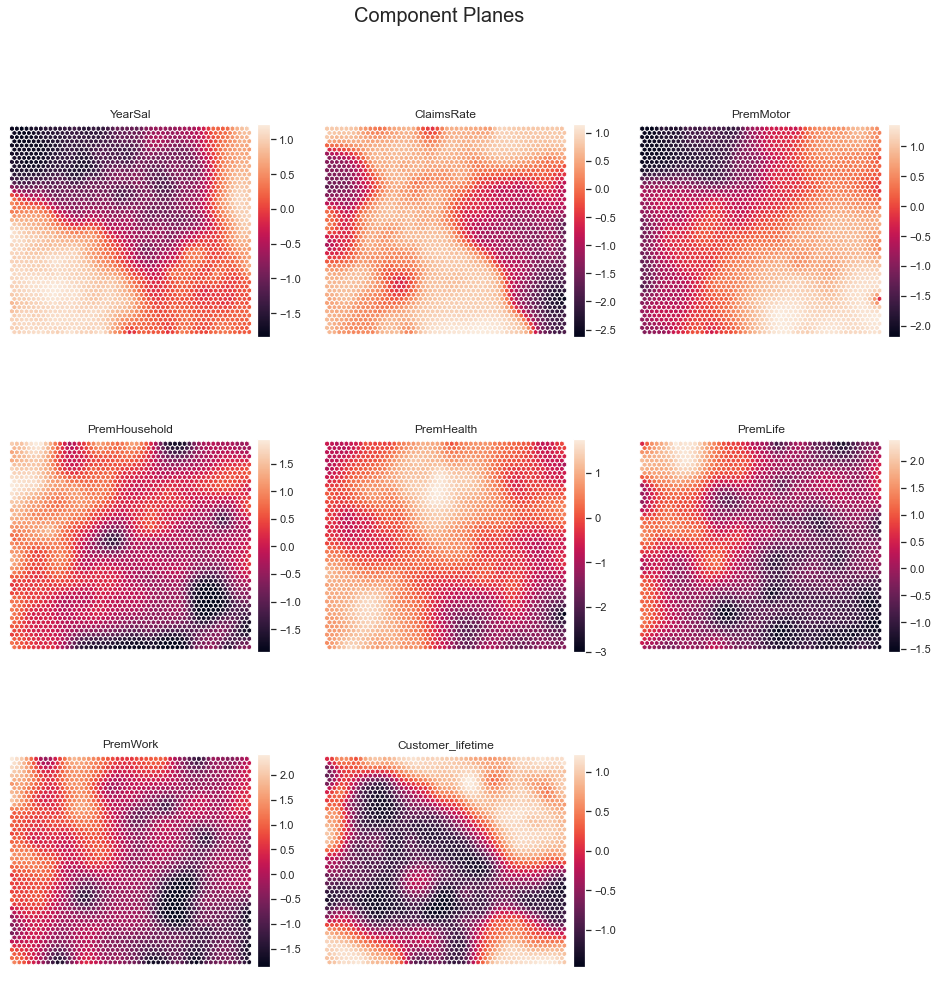

In [136]:
# Component planes on the 50x50 grid
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

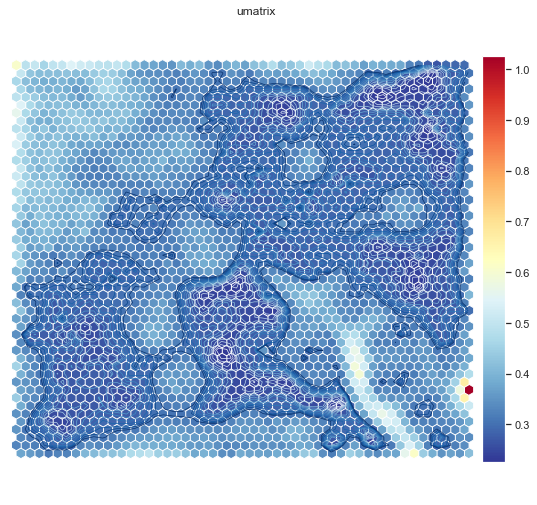

In [137]:
# U-matrix of the 50x50 grid
u = sompy.umatrix.UMatrixView(9, 9, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance=2, 
    row_normalized=False, 
    show_data=False, 
    contour=True # Visualize isomorphic curves
)

### K-Means on top of SOM units

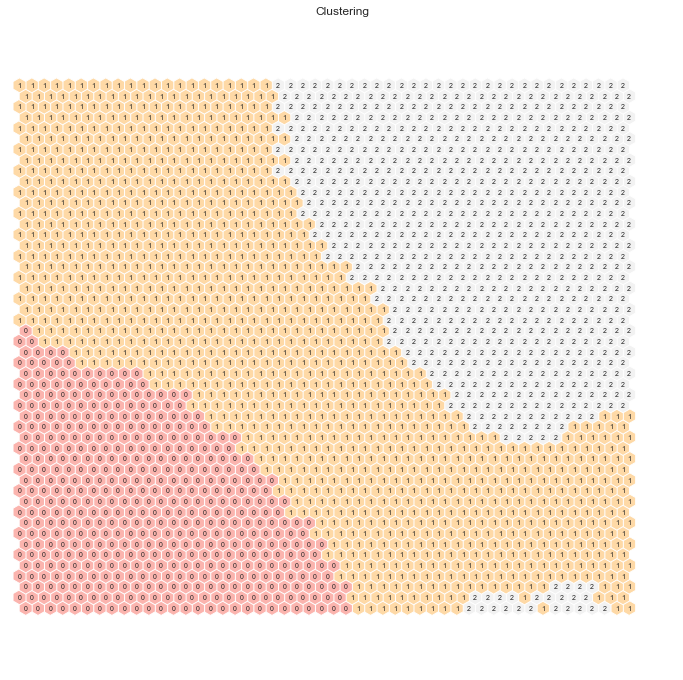

In [138]:
# Perform K-Means clustering on top of the 2500 untis (sm.get_node_vectors() output)
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=42)
nodeclus_labels = kmeans.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [139]:
# Check the nodes and and respective clusters
nodes = sm.codebook.matrix

df_nodes = pd.DataFrame(nodes, columns=metric_features)
df_nodes['label'] = nodeclus_labels
df_nodes

YearSal  ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  \
0     0.966665    0.775749   0.528921      -0.332828   -0.077083 -0.163273   
1     0.880369    0.817986   0.660518      -0.422264   -0.287892 -0.226357   
2     0.757562    0.819303   0.803285      -0.389838   -0.532128 -0.300013   
3     0.561256    0.789026   0.888871      -0.267652   -0.675868 -0.417763   
4     0.288412    0.810670   0.932890      -0.259264   -0.758428 -0.503679   
...        ...         ...        ...            ...         ...       ...   
2495  1.111547    0.291467  -0.839929       0.316857    1.496172 -0.293979   
2496  1.094956    0.367993  -0.821611       0.463234    1.296741 -0.184807   
2497  1.084266    0.366188  -0.881985       0.540146    1.114105 -0.048863   
2498  1.023731    0.592915  -0.911831       0.634139    0.910836 -0.036300   
2499  1.037174    0.662963  -1.012094       0.816868    0.692582  0.080852   

      PremWork  Customer_lifetime  label  
0     0.003840           1.121712      1  
1    -0.119177           1.112876      1  
2    -0.289381           1.121201      2  
3    -0.422938           1.137404      2  
4    -0.419352           1.184431      2  
...        ...                ...    ...  
2495  0.356275           1.118820      1  
2496  0.561313           1.137580      1  
2497  0.864122           1.070201      1  
2498  1.100203           0.949150      1  
2499  1.314892           0.915575      1  

[2500 rows x 9 columns]

In [140]:
# Obtaining SOM's BMUs labels
bmus_map = sm.find_bmu(df_scaled[metric_features])[0]  # get bmus for each observation in df

df_bmus = pd.DataFrame(
    np.concatenate((df_scaled[metric_features], np.expand_dims(bmus_map,1)), axis=1),
    index=df_scaled[metric_features].index, columns=np.append(df_scaled[metric_features].columns,"BMU")
)
df_bmus

YearSal  ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  \
0     -0.215198   -0.775697   0.612898      -0.315696   -0.150714  0.412395   
1     -2.199001    1.198655  -1.715005       1.004702   -0.570355  2.386076   
2     -0.113352   -1.209660  -0.493012       0.381985   -0.454004  1.090615   
3     -1.513488    0.910499  -0.679806      -0.583443    1.644320  0.158590   
4     -0.664095    0.699756   0.396238      -0.545548    0.307480 -0.289965   
...         ...         ...        ...            ...         ...       ...   
10217  0.727154    0.841358   0.713184      -0.531949    0.200957 -0.625804   
10218  0.039213   -3.617976  -1.108813       2.358961   -0.192569 -0.496911   
10219  0.492253   -1.532313   0.767647      -0.015650   -0.206124 -0.505478   
10220 -0.432655    0.051390  -0.630482       0.329994    0.492682  0.729044   
10221  0.399792   -1.253057   0.824474      -0.223160   -0.219726 -0.765680   

       PremWork  Customer_lifetime     BMU  
0     -0.303540           0.206362   757.0  
1      1.359670           0.776936    96.0  
2      1.265376          -0.723690   843.0  
3      0.022481          -0.561487   826.0  
4      0.321869           0.058051   265.0  
...         ...                ...     ...  
10217 -0.374791           0.352300  2229.0  
10218  1.346603           1.315736   749.0  
10219 -0.813449          -1.230819  1600.0  
10220  1.446688           0.776936    27.0  
10221 -0.443071          -0.561487  1459.0  

[10222 rows x 9 columns]

In [141]:
# Get cluster labels for each observation
df_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)
df_final

YearSal  ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  \
0     -0.215198   -0.775697   0.612898      -0.315696   -0.150714  0.412395   
1     -2.199001    1.198655  -1.715005       1.004702   -0.570355  2.386076   
2     -0.113352   -1.209660  -0.493012       0.381985   -0.454004  1.090615   
3     -1.513488    0.910499  -0.679806      -0.583443    1.644320  0.158590   
4     -0.664095    0.699756   0.396238      -0.545548    0.307480 -0.289965   
...         ...         ...        ...            ...         ...       ...   
10217  0.727154    0.841358   0.713184      -0.531949    0.200957 -0.625804   
10218  0.039213   -3.617976  -1.108813       2.358961   -0.192569 -0.496911   
10219  0.492253   -1.532313   0.767647      -0.015650   -0.206124 -0.505478   
10220 -0.432655    0.051390  -0.630482       0.329994    0.492682  0.729044   
10221  0.399792   -1.253057   0.824474      -0.223160   -0.219726 -0.765680   

       PremWork  Customer_lifetime     BMU  label  
0     -0.303540           0.206362   757.0      1  
1      1.359670           0.776936    96.0      0  
2      1.265376          -0.723690   843.0      0  
3      0.022481          -0.561487   826.0      1  
4      0.321869           0.058051   265.0      1  
...         ...                ...     ...    ...  
10217 -0.374791           0.352300  2229.0      1  
10218  1.346603           1.315736   749.0      0  
10219 -0.813449          -1.230819  1600.0      2  
10220  1.446688           0.776936    27.0      0  
10221 -0.443071          -0.561487  1459.0      2  

[10222 rows x 10 columns]

In [142]:
# using R²
sst = get_ss(df_final[metric_features])  # get total sum of squares
ssw_labels = df_final[metric_features + ["label"]].groupby(by='label').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  
r2 = ssb / sst
r2

0.3329757254002453

### Hierarchical Clustering on top of SOM units

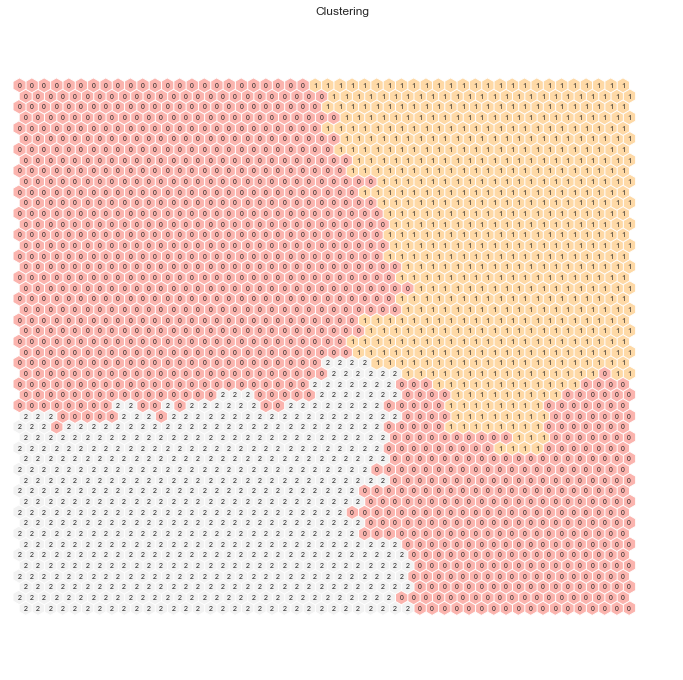

In [143]:
# Perform Hierarchical clustering on top of the 2500 untis (sm.get_node_vectors() output)
hierclust = AgglomerativeClustering(n_clusters=3, linkage='ward')
nodeclus_labels = hierclust.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits  = HitMapView(12, 12,"Clustering",text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [144]:
# Check the nodes and and respective clusters
nodes = sm.codebook.matrix

df_nodes = pd.DataFrame(nodes, columns=metric_features)
df_nodes['label'] = nodeclus_labels
df_nodes

YearSal  ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  \
0     0.966665    0.775749   0.528921      -0.332828   -0.077083 -0.163273   
1     0.880369    0.817986   0.660518      -0.422264   -0.287892 -0.226357   
2     0.757562    0.819303   0.803285      -0.389838   -0.532128 -0.300013   
3     0.561256    0.789026   0.888871      -0.267652   -0.675868 -0.417763   
4     0.288412    0.810670   0.932890      -0.259264   -0.758428 -0.503679   
...        ...         ...        ...            ...         ...       ...   
2495  1.111547    0.291467  -0.839929       0.316857    1.496172 -0.293979   
2496  1.094956    0.367993  -0.821611       0.463234    1.296741 -0.184807   
2497  1.084266    0.366188  -0.881985       0.540146    1.114105 -0.048863   
2498  1.023731    0.592915  -0.911831       0.634139    0.910836 -0.036300   
2499  1.037174    0.662963  -1.012094       0.816868    0.692582  0.080852   

      PremWork  Customer_lifetime  label  
0     0.003840           1.121712      0  
1    -0.119177           1.112876      0  
2    -0.289381           1.121201      0  
3    -0.422938           1.137404      0  
4    -0.419352           1.184431      0  
...        ...                ...    ...  
2495  0.356275           1.118820      0  
2496  0.561313           1.137580      0  
2497  0.864122           1.070201      0  
2498  1.100203           0.949150      0  
2499  1.314892           0.915575      0  

[2500 rows x 9 columns]

In [145]:
df_nodes['label'].unique()

array([0, 2, 1], dtype=int64)

In [146]:
# Obtaining SOM's BMUs labels
bmus_map = sm.find_bmu(df_scaled[metric_features])[0]  # get bmus for each observation in df

df_bmus = pd.DataFrame(
    np.concatenate((df_scaled[metric_features], np.expand_dims(bmus_map,1)), axis=1),
    index=df_scaled[metric_features].index, columns=np.append(df_scaled[metric_features].columns,"BMU")
)
df_bmus

YearSal  ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  \
0     -0.215198   -0.775697   0.612898      -0.315696   -0.150714  0.412395   
1     -2.199001    1.198655  -1.715005       1.004702   -0.570355  2.386076   
2     -0.113352   -1.209660  -0.493012       0.381985   -0.454004  1.090615   
3     -1.513488    0.910499  -0.679806      -0.583443    1.644320  0.158590   
4     -0.664095    0.699756   0.396238      -0.545548    0.307480 -0.289965   
...         ...         ...        ...            ...         ...       ...   
10217  0.727154    0.841358   0.713184      -0.531949    0.200957 -0.625804   
10218  0.039213   -3.617976  -1.108813       2.358961   -0.192569 -0.496911   
10219  0.492253   -1.532313   0.767647      -0.015650   -0.206124 -0.505478   
10220 -0.432655    0.051390  -0.630482       0.329994    0.492682  0.729044   
10221  0.399792   -1.253057   0.824474      -0.223160   -0.219726 -0.765680   

       PremWork  Customer_lifetime     BMU  
0     -0.303540           0.206362   757.0  
1      1.359670           0.776936    96.0  
2      1.265376          -0.723690   843.0  
3      0.022481          -0.561487   826.0  
4      0.321869           0.058051   265.0  
...         ...                ...     ...  
10217 -0.374791           0.352300  2229.0  
10218  1.346603           1.315736   749.0  
10219 -0.813449          -1.230819  1600.0  
10220  1.446688           0.776936    27.0  
10221 -0.443071          -0.561487  1459.0  

[10222 rows x 9 columns]

In [147]:
# Get cluster labels for each observation
df_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)
df_final

YearSal  ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  \
0     -0.215198   -0.775697   0.612898      -0.315696   -0.150714  0.412395   
1     -2.199001    1.198655  -1.715005       1.004702   -0.570355  2.386076   
2     -0.113352   -1.209660  -0.493012       0.381985   -0.454004  1.090615   
3     -1.513488    0.910499  -0.679806      -0.583443    1.644320  0.158590   
4     -0.664095    0.699756   0.396238      -0.545548    0.307480 -0.289965   
...         ...         ...        ...            ...         ...       ...   
10217  0.727154    0.841358   0.713184      -0.531949    0.200957 -0.625804   
10218  0.039213   -3.617976  -1.108813       2.358961   -0.192569 -0.496911   
10219  0.492253   -1.532313   0.767647      -0.015650   -0.206124 -0.505478   
10220 -0.432655    0.051390  -0.630482       0.329994    0.492682  0.729044   
10221  0.399792   -1.253057   0.824474      -0.223160   -0.219726 -0.765680   

       PremWork  Customer_lifetime     BMU  label  
0     -0.303540           0.206362   757.0      1  
1      1.359670           0.776936    96.0      2  
2      1.265376          -0.723690   843.0      2  
3      0.022481          -0.561487   826.0      2  
4      0.321869           0.058051   265.0      0  
...         ...                ...     ...    ...  
10217 -0.374791           0.352300  2229.0      0  
10218  1.346603           1.315736   749.0      2  
10219 -0.813449          -1.230819  1600.0      1  
10220  1.446688           0.776936    27.0      2  
10221 -0.443071          -0.561487  1459.0      1  

[10222 rows x 10 columns]

In [148]:
# Characterizing the final clusters
df_final.drop(columns='BMU').groupby('label').mean()

YearSal  ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  \
label                                                                         
0      0.491940    0.278722  -0.000319       0.025526    0.303259  0.059596   
1      0.067465   -0.611959   0.997859      -0.794432   -0.945302 -0.793443   
2     -1.181262    0.079300  -1.148152       0.857392    0.408045  0.779823   

       PremWork  Customer_lifetime  
label                               
0      0.056441           0.043952  
1     -0.841499          -0.078149  
2      0.842231          -0.008624

In [149]:
# using R²
sst = get_ss(df_final[metric_features])  # get total sum of squares
ssw_labels = df_final[metric_features + ["label"]].groupby(by='label').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
r2

0.3063058154407102

### Kmeans + Hierarchical Clustering


In [150]:
#Run Kmeans with 50 n_clusters 
kmclust_hier = KMeans(n_clusters= 50, init='k-means++', n_init=15, random_state=1)

In [151]:
km_labels_hier = kmclust_hier.fit_predict(df_scaled[metric_features])
km_labels_hier

array([16,  1, 15, ...,  8, 19, 37])

In [152]:
#Assign cluster labels to normalized data
km_hier = pd.concat((df_scaled[metric_features], pd.Series(km_labels_hier, name='Km_Label', 
                                                                   index=df_scaled[metric_features].index.tolist())), 
                               axis=1)
km_hier = km_hier.groupby('Km_Label').mean()
km_hier

YearSal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
Km_Label                                                               
0         0.258490    0.106164   0.574237      -0.160894   -0.082577   
1        -1.423198    0.527920  -1.694377      -0.258870    0.265172   
2         0.864026   -1.028911   0.604459      -0.143030   -0.184634   
3        -1.103042    0.284930  -0.775502       0.328340    1.345437   
4         0.788634    0.814118   0.575877      -0.243206   -0.037655   
5         0.787226   -1.207920  -0.696626       1.182539    0.308033   
6         0.145745    0.714734  -0.422643      -1.730155    0.818888   
7        -1.262500   -1.261087  -1.156748       1.702228    0.290161   
8         0.871321   -0.886994   0.569295      -0.202687    0.021087   
9         0.154625    0.964169   1.303519      -1.023396   -1.563067   
10        0.190733   -1.695573   1.265515      -1.954422   -1.384664   
11        0.487788    0.069494   0.312504       0.525686   -0.454377   
12        0.191086    0.811260   1.141548      -0.374351   -1.225153   
13       -1.639984    0.597060  -1.829155       1.598978   -0.134481   
14        1.116322    0.195174  -0.527579       0.371419    1.145941   
15        0.751192   -0.923529  -0.199237       0.826952   -0.204475   
16       -0.672337   -0.933095   0.516459      -0.171538    0.125336   
17       -1.552195    0.311446  -1.615939       0.898875    0.977921   
18        1.125561    0.616107  -1.072093       0.439145    1.164179   
19       -0.926325   -0.367567  -0.229695       0.034336   -0.017020   
20       -0.733212   -0.979733   0.511361      -0.178654    0.094811   
21       -0.441911    0.851080   0.739958      -0.634242   -0.204895   
22        0.806538    0.392305  -0.938003       0.878523    0.398606   
23        0.141358   -1.768484   1.217269      -0.488132   -1.294107   
24        0.222330    1.144452   1.052613      -1.944617   -0.819541   
25        1.053082    0.165648  -0.253815       0.000522    1.159415   
26       -1.797869    0.657202  -2.134728       1.821861   -0.542723   
27       -0.595871    0.854960   0.615287      -0.492146    0.113654   
28       -1.608745   -1.408987  -1.899344       1.771489   -0.512454   
29       -0.504909    0.643384  -0.190027       0.700444   -0.029055   
30        0.041338   -1.133601   0.915842      -1.905096   -0.482125   
31       -0.223085   -3.617976  -3.650461      -1.340230   -4.069137   
32        1.097000    0.663268   0.064323      -0.678348    0.831994   
33        0.101753    0.958909   1.283813      -0.950712   -1.425145   
34       -0.397285    0.382677  -0.801218       1.115934   -0.349132   
35       -0.959020    0.330208  -0.696780       0.245726    1.405913   
36       -0.726447    0.503639  -0.003098       0.080080    0.412855   
37        0.228425   -1.541305   0.989789      -0.318822   -0.957337   
38        0.995457    0.357408  -0.980341       0.514472    0.233065   
39        0.043771    0.205213   0.025929       0.261970    0.631837   
40       -1.453054    0.665385  -1.697058       0.985641    0.815078   
41        0.095826   -2.025635   1.348318      -0.890852   -1.723237   
42        0.863863    0.491923  -0.186775       0.431731    0.037338   
43       -0.078185   -0.404429  -0.212464       0.049798   -4.069137   
44        0.756820    0.718877   0.691201      -0.059774   -0.474339   
45       -1.159023   -0.924499  -1.213795       1.285689    0.449180   
46       -0.776818    0.422966   0.035766      -0.012139    0.805230   
47        0.340767   -0.573877   0.453644      -1.773783    0.195146   
48        0.634545    0.161015  -0.114303       0.344738    0.761052   
49       -1.665428    0.588746  -1.967217       1.123203   -0.821565   

          PremLife  PremWork  Customer_lifetime  
Km_Label                                         
0        -0.244764 -1.905643          -0.824546  
1         2.057136  1.511684           0.366323  
2        -0.321937 -0.222647           0.877570  
3         0.3619

### Run HClustering with the 50 kmeans clusters

In [153]:
linkage = 'ward'
distance = 'euclidean'
hc = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=None, distance_threshold=0)
hc.fit_predict(km_hier)

array([31, 34, 40, 45, 41, 35, 46, 47, 42, 30, 43, 49, 33, 37, 22, 26, 28,
       32, 44, 39, 38, 48, 16, 20, 36, 15, 27, 18, 21, 19, 13, 24, 23, 17,
       25, 11,  8, 12, 29, 10, 14,  5,  7,  6,  3,  9,  4,  1,  2,  0],
      dtype=int64)

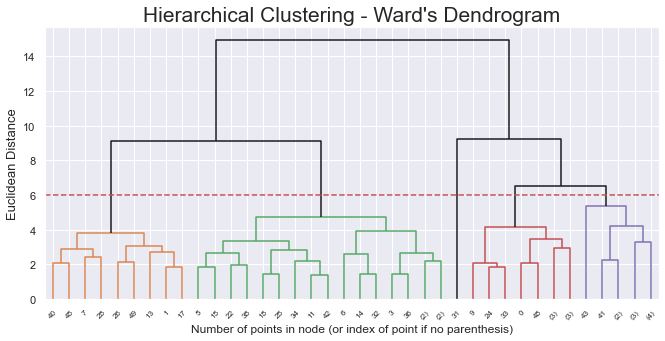

In [154]:
# Create the counts of samples under each node (number of points being merged)
counts = np.zeros(hc.children_.shape[0])
n_samples = len(hc.labels_)


for i, merge in enumerate(hc.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([hc.children_, hc.distances_, counts]).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned. Already have an idea of 3 or 4 clusters bc of Kmeans.
y_threshold = 6
#Build the dendogram
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [155]:
# given the dendogram, define the clusters. 
hclust=AgglomerativeClustering(linkage='ward',affinity='euclidean',n_clusters=3)
hc_labels=hclust.fit_predict(km_hier)

In [156]:
#characterization with normalized data per cluster-HC
labeled_hc = pd.concat((km_hier, pd.Series(hc_labels, name='hc_labels')), axis=1)
#labeled_hc_normalized
hier_labeled = labeled_hc.groupby('hc_labels').mean()
hier_labeled['hc_labels'] = hier_labeled.index
hier_labeled

YearSal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
hc_labels                                                               
0         -0.360225    0.129186  -0.843304       0.599419    0.362931   
1          0.154742   -0.244610   0.730417      -0.602448   -0.635668   
2         -0.223085   -3.617976  -3.650461      -1.340230   -4.069137   

           PremLife  PremWork  Customer_lifetime  hc_labels  
hc_labels                                                    
0          0.706187  0.675176          -0.041761          0  
1         -0.616511 -0.652740           0.029939          1  
2         -1.496462 -1.407408          -0.177711          2

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'YearSal'),
  Text(1, 0, 'ClaimsRate'),
  Text(2, 0, 'PremMotor'),
  Text(3, 0, 'PremHousehold'),
  Text(4, 0, 'PremHealth'),
  Text(5, 0, 'PremLife'),
  Text(6, 0, 'PremWork'),
  Text(7, 0, 'Customer_lifetime')])

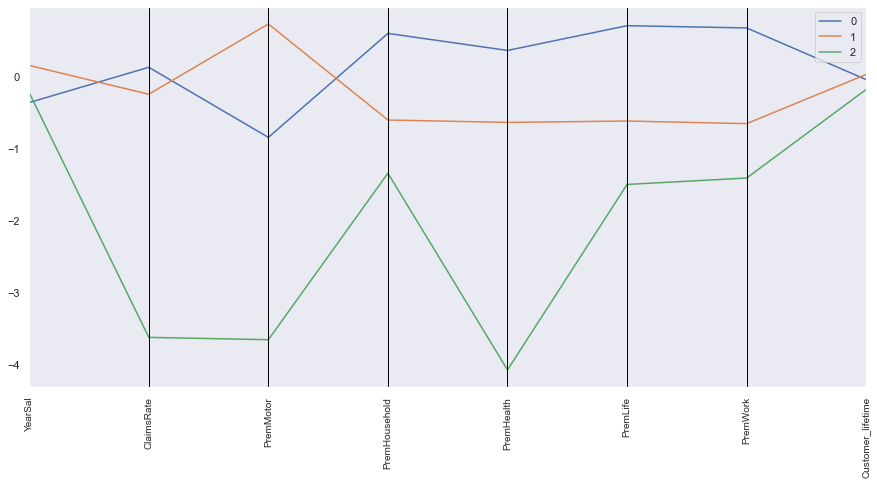

In [157]:
plt.figure(figsize=(15, 7))
pd.plotting.parallel_coordinates(hier_labeled, class_column = 'hc_labels', color=sns.color_palette())
plt.xticks(fontsize=10, rotation=90)

In [158]:
# using R²

sst = get_ss(labeled_hc[metric_features])  # get total sum of squares
ssw_labels = labeled_hc[metric_features + ["hc_labels"]].groupby(by='hc_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels) 
r2 = ssb / sst
r2

0.4135594162749062

## DBSCAN

#### Number of Estimated Clusters (while varying eps)

In [159]:
# Perform DBSCAN clustering
for i in np.arange(0.4, 1.7, 0.1):
    dbscan = DBSCAN(eps=i, min_samples=10, n_jobs=-1)
    dbscan_labels = dbscan.fit_predict(df_scaled[metric_features])

    dbscan_n_clusters = len(np.unique(dbscan_labels))
    print("Number of estimated clusters with eps =", np.round(i,2),":", dbscan_n_clusters)

Number of estimated clusters with eps = 0.4 : 1
Number of estimated clusters with eps = 0.5 : 1
Number of estimated clusters with eps = 0.6 : 10
Number of estimated clusters with eps = 0.7 : 22
Number of estimated clusters with eps = 0.8 : 12
Number of estimated clusters with eps = 0.9 : 4
Number of estimated clusters with eps = 1.0 : 5
Number of estimated clusters with eps = 1.1 : 2
Number of estimated clusters with eps = 1.2 : 2
Number of estimated clusters with eps = 1.3 : 2
Number of estimated clusters with eps = 1.4 : 2
Number of estimated clusters with eps = 1.5 : 2
Number of estimated clusters with eps = 1.6 : 2


#### Varying both eps and min_samples

In [160]:
for i in np.arange(0.4, 1.7, 0.1):
    print("eps=",np.round(np.average(i),1)," ",sep="")
    for samp in range(10,80,5):
        dbscan = DBSCAN(eps=i, min_samples=samp, n_jobs=-1)
        dbscan_labels = dbscan.fit_predict(df_scaled[metric_features])

        dbscan_n_clusters = len(np.unique(dbscan_labels))
        
        # Concatenating the labels to df
        df_concat = pd.concat([df_scaled[metric_features], pd.Series(dbscan_labels, index=df_scaled.index, name="dbscan_labels")], axis=1)
        
        # Detecting noise (potential outliers)
        outliers=len(df_concat.loc[df_concat['dbscan_labels'] == -1])
        
        # Computing the R^2 of the cluster solution
        df_nonoise = df_concat.loc[df_concat['dbscan_labels'] != -1]
        sst = get_ss(df_scaled[metric_features])  # get total sum of squares
        ssw_labels = df_nonoise.groupby(by='dbscan_labels').apply(get_ss)  # compute ssw for each cluster labels
        ssb = sst - np.sum(ssw_labels)  
        r2 = ssb / sst
        #print("Cluster solution with R^2 of %0.4f" % r2)
        
        print("Clusters w/ eps=",np.round(np.average(i),1),
          ", min_samples=", samp,": ", dbscan_n_clusters, " clusters w/ R2=", np.round(np.average(r2),4), " & outlier rows=",outliers, sep="")

    print("\n")

eps=0.4 
Clusters w/ eps=0.4, min_samples=10: 1 clusters w/ R2=nan & outlier rows=10222
Clusters w/ eps=0.4, min_samples=15: 1 clusters w/ R2=nan & outlier rows=10222
Clusters w/ eps=0.4, min_samples=20: 1 clusters w/ R2=nan & outlier rows=10222
Clusters w/ eps=0.4, min_samples=25: 1 clusters w/ R2=nan & outlier rows=10222
Clusters w/ eps=0.4, min_samples=30: 1 clusters w/ R2=nan & outlier rows=10222
Clusters w/ eps=0.4, min_samples=35: 1 clusters w/ R2=nan & outlier rows=10222
Clusters w/ eps=0.4, min_samples=40: 1 clusters w/ R2=nan & outlier rows=10222
Clusters w/ eps=0.4, min_samples=45: 1 clusters w/ R2=nan & outlier rows=10222
Clusters w/ eps=0.4, min_samples=50: 1 clusters w/ R2=nan & outlier rows=10222
Clusters w/ eps=0.4, min_samples=55: 1 clusters w/ R2=nan & outlier rows=10222
Clusters w/ eps=0.4, min_samples=60: 1 clusters w/ R2=nan & outlier rows=10222
Clusters w/ eps=0.4, min_samples=65: 1 clusters w/ R2=nan & outlier rows=10222
Clusters w/ eps=0.4, min_samples=70: 1 clus

Clusters w/ eps=1.1, min_samples=30: 2 clusters w/ R2=0.5485 & outlier rows=3375
Clusters w/ eps=1.1, min_samples=35: 2 clusters w/ R2=0.591 & outlier rows=3759
Clusters w/ eps=1.1, min_samples=40: 2 clusters w/ R2=0.6176 & outlier rows=4018
Clusters w/ eps=1.1, min_samples=45: 2 clusters w/ R2=0.6413 & outlier rows=4257
Clusters w/ eps=1.1, min_samples=50: 2 clusters w/ R2=0.6712 & outlier rows=4553
Clusters w/ eps=1.1, min_samples=55: 2 clusters w/ R2=0.6979 & outlier rows=4844
Clusters w/ eps=1.1, min_samples=60: 2 clusters w/ R2=0.719 & outlier rows=5082
Clusters w/ eps=1.1, min_samples=65: 2 clusters w/ R2=0.7438 & outlier rows=5371
Clusters w/ eps=1.1, min_samples=70: 2 clusters w/ R2=0.7618 & outlier rows=5614
Clusters w/ eps=1.1, min_samples=75: 2 clusters w/ R2=0.7836 & outlier rows=5909


eps=1.2 
Clusters w/ eps=1.2, min_samples=10: 2 clusters w/ R2=0.2186 & outlier rows=1047
Clusters w/ eps=1.2, min_samples=15: 2 clusters w/ R2=0.2715 & outlier rows=1366
Clusters w/ eps=1.2

#### Varying min_samples while keeping eps constant (eps = 0.7)

In [161]:
for samp in range(1,15,1):
    dbscan = DBSCAN(eps=0.7, min_samples=samp, n_jobs=4)
    dbscan_labels = dbscan.fit_predict(df_scaled[metric_features])

    dbscan_n_clusters = len(np.unique(dbscan_labels))

    # Concatenating the labels to df
    df_concat = pd.concat([df_scaled[metric_features], pd.Series(dbscan_labels, index=df_scaled.index, name="dbscan_labels")], axis=1)

    # Detecting noise (potential outliers)
    outliers=len(df_concat.loc[df_concat['dbscan_labels'] == -1])
    
    # Computing the R^2 of the cluster solution
    df_nonoise = df_concat.loc[df_concat['dbscan_labels'] != -1]
    sst = get_ss(df_scaled[metric_features])  # get total sum of squares
    ssw_labels = df_nonoise.groupby(by='dbscan_labels').apply(get_ss)  # compute ssw for each cluster labels
    ssb = sst - np.sum(ssw_labels)  
    r2 = ssb / sst
    #print("Cluster solution with R^2 of %0.4f" % r2)

    print("Clusters w/ eps=",i,
          ", min_samples=", samp,": ", dbscan_n_clusters, " clusters w/ R2=", np.round(np.average(r2),4), " & outlier rows=",outliers, sep="")

print("\n")

Clusters w/ eps=1.5999999999999996, min_samples=1: 4969 clusters w/ R2=0.7656 & outlier rows=0
Clusters w/ eps=1.5999999999999996, min_samples=2: 678 clusters w/ R2=0.7656 & outlier rows=4292
Clusters w/ eps=1.5999999999999996, min_samples=3: 205 clusters w/ R2=0.7666 & outlier rows=5238
Clusters w/ eps=1.5999999999999996, min_samples=4: 121 clusters w/ R2=0.8066 & outlier rows=5978
Clusters w/ eps=1.5999999999999996, min_samples=5: 57 clusters w/ R2=0.8369 & outlier rows=6690
Clusters w/ eps=1.5999999999999996, min_samples=6: 47 clusters w/ R2=0.867 & outlier rows=7193
Clusters w/ eps=1.5999999999999996, min_samples=7: 35 clusters w/ R2=0.8942 & outlier rows=7639
Clusters w/ eps=1.5999999999999996, min_samples=8: 29 clusters w/ R2=0.9193 & outlier rows=8032
Clusters w/ eps=1.5999999999999996, min_samples=9: 34 clusters w/ R2=0.952 & outlier rows=8352
Clusters w/ eps=1.5999999999999996, min_samples=10: 22 clusters w/ R2=0.9611 & outlier rows=8648
Clusters w/ eps=1.5999999999999996, min

## Mean Shift Clustering

#### Varying quantile

In [162]:
# The following bandwidth can be automatically detected using (we need to set quantile though)
# Based on distance to nearest neighbors for all observations

for i in np.arange(0.02, 0.10, 0.02):
    bandwidth = estimate_bandwidth(df_scaled[metric_features], quantile=i, random_state=1, n_jobs=-1)
    
    # Perform mean-shift clustering with bandwidth set using estimate_bandwidth
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1, max_iter = 500)
    ms_labels = ms.fit_predict(df_scaled[metric_features])

    ms_n_clusters = len(np.unique(ms_labels))
    
    
    # Concatenating the labels to df
    df_concat = pd.concat([df_scaled[metric_features], pd.Series(ms_labels, index=df_scaled.index, name="ms_labels")], axis=1)
    
    # Computing the R^2 of the cluster solution
    sst = get_ss(df_scaled[metric_features])  # get total sum of squares
    ssw_labels = df_concat.groupby(by='ms_labels').apply(get_ss)  # compute ssw for each cluster labels
    ssb = sst - np.sum(ssw_labels) 
    r2 = ssb / sst
    print("bandwidth: ",np.round(bandwidth,2), ", quantile: ", i,
          ", # clusters: %d" % ms_n_clusters, ", R^2 of %0.4f" % r2, sep="")


bandwidth: 1.81, quantile: 0.02, # clusters: 60, R^2 of 0.4286
bandwidth: 2.06, quantile: 0.04, # clusters: 28, R^2 of 0.3121
bandwidth: 2.23, quantile: 0.06, # clusters: 14, R^2 of 0.2260
bandwidth: 2.37, quantile: 0.08, # clusters: 6, R^2 of 0.1626


## GMM (Gaussian Mixture Model)

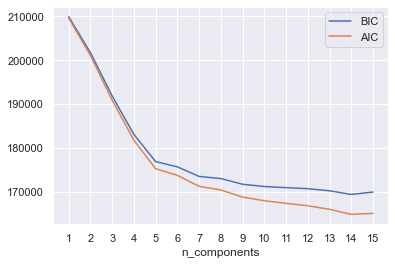

In [163]:
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df_scaled[metric_features])
          for n in n_components]

bic_values = [m.bic(df_scaled[metric_features]) for m in models]
aic_values = [m.aic(df_scaled[metric_features]) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

In [164]:
def GMM_tester(n_comp,n_init):
    # Performing GMM clustering
    gmm = GaussianMixture(n_components=n_comp, covariance_type='full', n_init=n_init, init_params='kmeans', random_state=1)
    gmm_labels = gmm.fit_predict(df_scaled[metric_features])

    # Concatenating the labels to df
    df_concat = pd.concat([df_scaled[metric_features], pd.Series(gmm_labels, index=df_scaled.index, name="gmm_labels")], axis=1)

    # Computing the R^2 of the cluster solution
    sst = get_ss(df_scaled[metric_features])  # get total sum of squares
    ssw_labels = df_concat.groupby(by='gmm_labels').apply(get_ss)  # compute ssw for each cluster labels
    ssb = sst - np.sum(ssw_labels)  
    r2 = ssb / sst
    print("# components: 2, cluster solution with R^2 of %0.4f" % r2, sep="")
    
    # Characterizing the clusters
    gmm_final=df_concat.groupby('gmm_labels').mean()
    gmm_final['gmm_labels'] = gmm_final.index 
    return gmm_final

In [165]:
GMM_tester(2,100)

# components: 2, cluster solution with R^2 of 0.2389


YearSal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
gmm_labels                                                               
0          -0.172247    0.156855  -0.733835       0.562255    0.512713   
1           0.183884   -0.167452   0.783411      -0.600239   -0.547350   

            PremLife  PremWork  Customer_lifetime  gmm_labels  
gmm_labels                                                     
0           0.562404  0.549505          -0.017480           0  
1          -0.600398 -0.586628           0.018661           1

In [166]:
GMM_tester(2,500)

# components: 2, cluster solution with R^2 of 0.2389


YearSal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
gmm_labels                                                               
0          -0.172247    0.156855  -0.733835       0.562255    0.512713   
1           0.183884   -0.167452   0.783411      -0.600239   -0.547350   

            PremLife  PremWork  Customer_lifetime  gmm_labels  
gmm_labels                                                     
0           0.562404  0.549505          -0.017480           0  
1          -0.600398 -0.586628           0.018661           1

In [167]:
GMM_tester(4,100)

# components: 2, cluster solution with R^2 of 0.3066


YearSal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
gmm_labels                                                               
0           0.194761    0.911567   0.922289      -0.749694   -0.628707   
1           0.205417   -0.164178   0.163950       0.079373    0.272141   
2          -0.604626   -0.004266  -1.293243       1.024380    0.312803   
3           0.132835   -0.868148   0.456924      -1.079255   -0.574049   

            PremLife  PremWork  Customer_lifetime  gmm_labels  
gmm_labels                                                     
0          -0.716461 -0.718310           0.014933           0  
1          -0.100483  0.028957           0.000288           1  
2           0.968889  0.985562          -0.018486           2  
3          -0.381303 -0.873640           0.011071           3

In [168]:
GMM_tester(5,100)

# components: 2, cluster solution with R^2 of 0.3327


YearSal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
gmm_labels                                                               
0          -0.609078    0.086675  -1.196099       0.738355    0.279437   
1           0.171192    0.140865  -0.194455       0.326482    0.499231   
2          -0.154569   -1.608198  -1.218104      -0.325456   -1.849345   
3           0.150723   -1.325050   0.923466      -0.780243   -0.639841   
4           0.182980    0.900754   0.930212      -0.749121   -0.648749   

            PremLife  PremWork  Customer_lifetime  gmm_labels  
gmm_labels                                                     
0           0.783677  0.747369           0.000281           0  
1           0.265802  0.281157          -0.002364           1  
2          -0.055435 -0.151796           0.064664           2  
3          -0.726935 -0.720624          -0.017143           3  
4          -0.736760 -0.729263           0.016505           4

## Clustering by Perspectives

In [169]:
demographic_features = [
    'YearSal',
    'EducDeg',
    'Children'
]

product_features=[
    'PremMotor',
    'PremHealth',
    'PremLife',
    'PremHousehold'
    
]

client_features=[
    'ClaimsRate',
        'Customer_lifetime', 
        'TotalPrem'
           
]

df_dem = df_scaled[demographic_features].copy()
df_pr = df_scaled[product_features].copy()
df_cl=df_scaled[client_features].copy()

In [170]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust


# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    affinity='euclidean'
)

#### Demographic Variables: 

In [171]:
# Obtaining the R² scores for each cluster solution on demographic variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_dem, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_dem, hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

kmeans  complete   average    single      ward
2  0.407665  0.396543  0.007876  0.055509  0.306950
3  0.563040  0.495803  0.393741  0.214956  0.473634
4  0.671410  0.596441  0.399285  0.292630  0.626989
5  0.728710  0.656271  0.531307  0.325512  0.705384
6  0.778233  0.701053  0.675542  0.370397  0.744553
7  0.805259  0.705261  0.678519  0.503171  0.781498
8  0.826227  0.729549  0.693247  0.580499  0.803073
9  0.842418  0.738252  0.740595  0.580851  0.822278

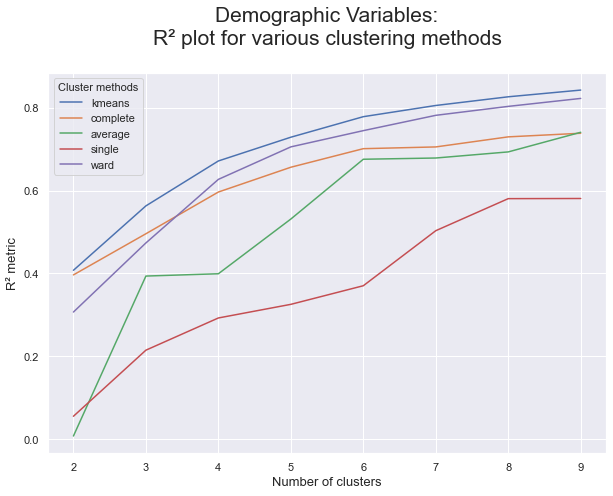

In [172]:
# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Demographic Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

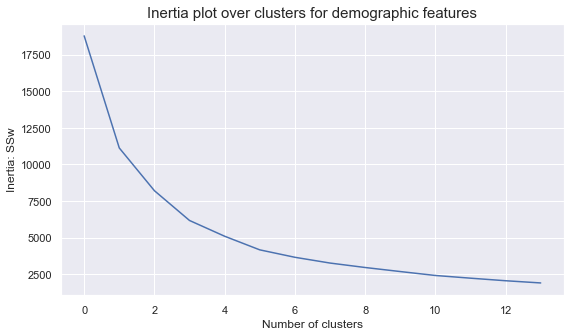

In [173]:
range_clusters = range(1, 15)
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_dem)
    inertia.append(kmclust.inertia_)
    
    # The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
ax.set_xlim(1, 24)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters for demographic features", size=15)
plt.show()

#### Product Variables: 

In [174]:
# Obtaining the R² scores for each cluster solution on product variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_pr, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_dem, hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

kmeans  complete   average    single      ward
2  0.404322  0.396543  0.007876  0.055509  0.306950
3  0.538533  0.495803  0.393741  0.214956  0.473634
4  0.604178  0.596441  0.399285  0.292630  0.626989
5  0.643094  0.656271  0.531307  0.325512  0.705384
6  0.672886  0.701053  0.675542  0.370397  0.744553
7  0.700678  0.705261  0.678519  0.503171  0.781498
8  0.723494  0.729549  0.693247  0.580499  0.803073
9  0.740364  0.738252  0.740595  0.580851  0.822278

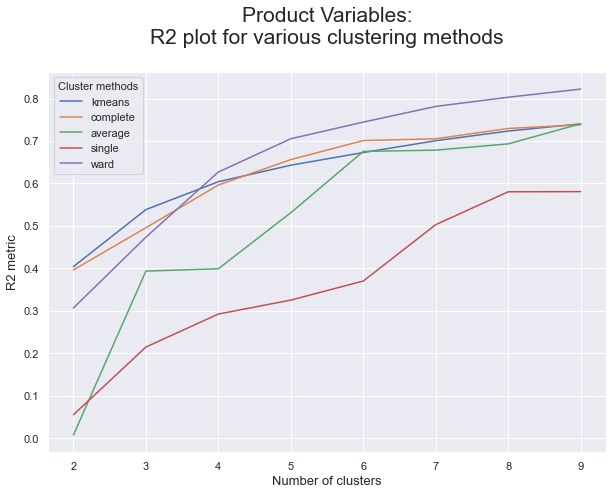

In [175]:
# Visualizing the R² scores for each cluster solution on product variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Product Variables:\nR2 plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)
plt.show()

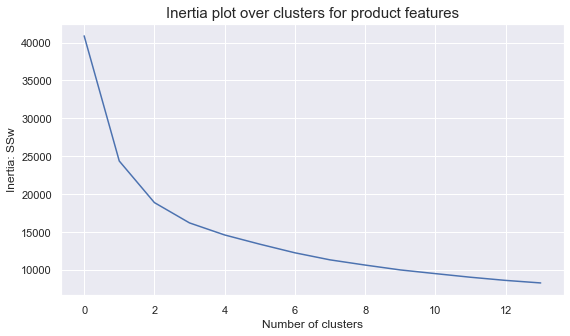

In [176]:
range_clusters = range(1, 15)
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_pr)
    inertia.append(kmclust.inertia_)
    
    # The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
ax.set_xlim(1, 24)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters for product features", size=15)
plt.show()

#### Client Variables: 

In [177]:
# Obtaining the R² scores for each cluster solution on client variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_cl, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_dem, hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

kmeans  complete   average    single      ward
2  0.248109  0.396543  0.007876  0.055509  0.306950
3  0.421589  0.495803  0.393741  0.214956  0.473634
4  0.560209  0.596441  0.399285  0.292630  0.626989
5  0.621799  0.656271  0.531307  0.325512  0.705384
6  0.658480  0.701053  0.675542  0.370397  0.744553
7  0.690291  0.705261  0.678519  0.503171  0.781498
8  0.717368  0.729549  0.693247  0.580499  0.803073
9  0.741825  0.738252  0.740595  0.580851  0.822278

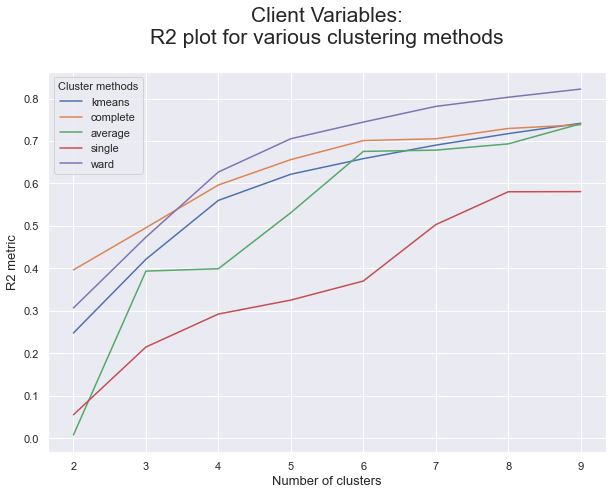

In [178]:
# Visualizing the R² scores for each cluster solution on client variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Client Variables:\nR2 plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)
plt.show()

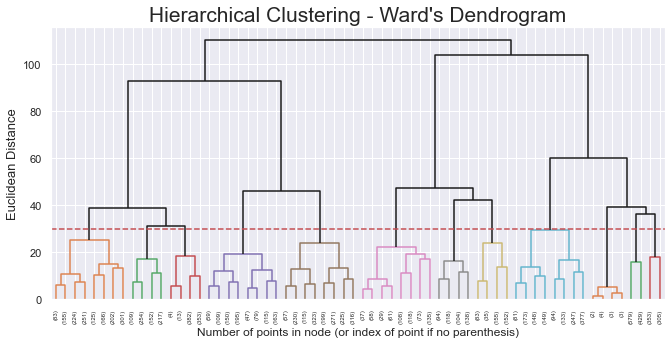

In [179]:
linkage = 'ward'
distance = 'euclidean'
hc = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=None, distance_threshold=0)
hc.fit_predict(df_cl)
# Create the counts of samples under each node (number of points being merged)
counts = np.zeros(hc.children_.shape[0])
n_samples = len(hc.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hc.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([hc.children_, hc.distances_, counts]).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned. Already have an idea of 3 or 4 clusters bc of Kmeans.
y_threshold = 30
#Build the dendogram
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

### Final methods: 

In [180]:
# Applying the right clustering (algorithm and number of clusters) for each perspective
kmeans_prod = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=20,
    random_state=42
)
prod_labels = kmeans_prod.fit_predict(df_pr)

kmeans_demo = KMeans(
    n_clusters=2,
    init='k-means++',
    n_init=20,
    random_state=42
)
demo_labels = kmeans_demo.fit_predict(df_dem)

hc_client = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=3

)
client_labels = hc_client.fit_predict(df_cl)

df_scaled['product_labels'] = prod_labels
df_scaled['demographic_labels'] = demo_labels
df_scaled['client_labels']=client_labels

### Merging using Hierarchical clustering

In [181]:
# Centroids of the concatenated cluster labels
df_centroids = df_scaled.groupby(['demographic_labels', 'product_labels', 'client_labels'])\
    [metric_features].mean()
df_centroids

YearSal  ClaimsRate  \
demographic_labels product_labels client_labels                         
0                  0              0             -0.822116    0.577923   
                                  1             -0.826161   -0.590601   
                                  2             -0.945174   -0.622919   
                   1              0             -0.537697    0.849234   
                                  1             -0.562503   -1.385056   
                                  2             -0.672353   -1.472698   
                   2              0             -1.284384    0.641301   
                                  1             -1.253837   -0.768756   
                                  2             -1.427776   -0.269560   
1                  0              0              0.885932    0.568918   
                                  1              0.853938   -0.602304   
                                  2              0.830850   -0.660245   
                   1              0              0.523355    0.857541   
                                  1              0.503730   -1.465330   
                                  2              0.530352   -1.492782   
                   2              0              0.934413    0.575424   
                                  1              0.921544   -0.796318   
                                  2              0.915460   -0.329047   

                                                 PremMotor  PremHousehold  \
demographic_labels product_labels client_labels                             
0                  0              0              -0.173138       0.023073   
                                  1               0.010224      -0.215901   
                                  2              -0.430113       1.060182   
                   1              0               0.950253      -0.745097   
                                  1               0.894580      -0.791592   
                                  2               0.610250       0.626260   
                   2              0              -1.426951       0.624811   
                                  1              -1.310707       0.246205   
                                  2              -1.622382       1.702955   
1                  0              0              -0.091003       0.024087   
                                  1               0.067200      -0.184200   
                                  2              -0.234908       1.044369   
                   1              0               1.015273      -0.751098   
                                  1               1.014585      -0.828989   
                                  2               0.733899       0.619727   
                   2              0              -0.972784       0.634121   
                                  1              -0.903086       0.349769   
                                  2              -0.929306       1.472287   

                                                 PremHealth  PremLife  \
demographic_labels product_labels client_labels                         
0                  0              0                0.752926 -0.003144   
                                  1                0.628743 -0.010607   
                                  2                0.532084 -0.372541   
                   1              0               -0.777240 -0.780992   
                                  1               -0.821892 -0.756114   
                                  2               -0.839901 -0.386717   
                   2              0                0.312332  1.432467   
                                  1                0.145783  1.686939   
                                  2               -0.106189  1.139951   
1                  0              0                0.625136  0.032440   
                                  1                0.532135 -0.005608   
                                  2                0.299694 -0.212791   
                   1      

## Merge

In [182]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

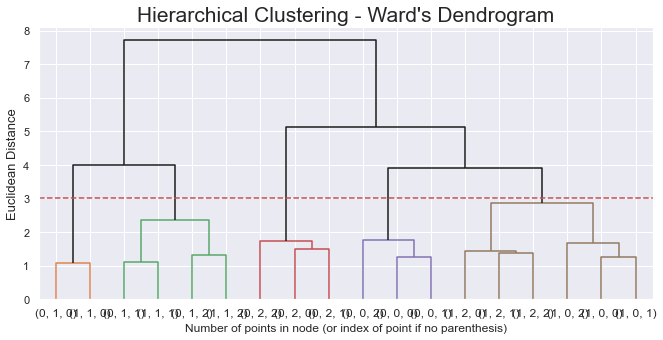

In [183]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 3
dendrogram(linkage_matrix, truncate_mode='level', labels=df_centroids.index, p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [184]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=3
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

YearSal  ClaimsRate  \
demographic_labels product_labels client_labels                         
0                  0              0             -0.822116    0.577923   
                                  1             -0.826161   -0.590601   
                                  2             -0.945174   -0.622919   
                   1              0             -0.537697    0.849234   
                                  1             -0.562503   -1.385056   
                                  2             -0.672353   -1.472698   
                   2              0             -1.284384    0.641301   
                                  1             -1.253837   -0.768756   
                                  2             -1.427776   -0.269560   
1                  0              0              0.885932    0.568918   
                                  1              0.853938   -0.602304   
                                  2              0.830850   -0.660245   
                   1              0              0.523355    0.857541   
                                  1              0.503730   -1.465330   
                                  2              0.530352   -1.492782   
                   2              0              0.934413    0.575424   
                                  1              0.921544   -0.796318   
                                  2              0.915460   -0.329047   

                                                 PremMotor  PremHousehold  \
demographic_labels product_labels client_labels                             
0                  0              0              -0.173138       0.023073   
                                  1               0.010224      -0.215901   
                                  2              -0.430113       1.060182   
                   1              0               0.950253      -0.745097   
                                  1               0.894580      -0.791592   
                                  2               0.610250       0.626260   
                   2              0              -1.426951       0.624811   
                                  1              -1.310707       0.246205   
                                  2              -1.622382       1.702955   
1                  0              0              -0.091003       0.024087   
                                  1               0.067200      -0.184200   
                                  2              -0.234908       1.044369   
                   1              0               1.015273      -0.751098   
                                  1               1.014585      -0.828989   
                                  2               0.733899       0.619727   
                   2              0              -0.972784       0.634121   
                                  1              -0.903086       0.349769   
                                  2              -0.929306       1.472287   

                                                 PremHealth  PremLife  \
demographic_labels product_labels client_labels                         
0                  0              0                0.752926 -0.003144   
                                  1                0.628743 -0.010607   
                                  2                0.532084 -0.372541   
                   1              0               -0.777240 -0.780992   
                                  1               -0.821892 -0.756114   
                                  2               -0.839901 -0.386717   
                   2              0                0.312332  1.432467   
                                  1                0.145783  1.686939   
                                  2               -0.106189  1.139951   
1                  0              0                0.625136  0.032440   
                                  1                0.532135 -0.005608   
                                  2                0.299694 -0.212791   
                   1      

In [185]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_ = df_scaled.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['demographic_labels'], row['product_labels'], row['client_labels'])
    ], axis=1
)

# Merged cluster centroids
df_.groupby('merged_labels').mean()[metric_features]

YearSal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
merged_labels                                                               
0              0.161489   -0.220849   0.982109      -0.766825   -0.924765   
1              0.275301    0.124460  -0.205747       0.168450    0.570686   
2             -1.356907    0.061877  -1.520270       1.159074    0.081730   

               PremLife  PremWork  Customer_lifetime  
merged_labels                                         
0             -0.769330 -0.659511           0.010323  
1              0.131052  0.133733          -0.002873  
2              1.298747  1.036767          -0.013435

In [186]:
# Setting df to have the final product, behavior and merged clusters
df_final = df_.copy()

In [187]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_final[metric_features])  # get total sum of squares
ssw_labels = df_final[metric_features + ["merged_labels"]].groupby(by='merged_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels) 
r2 = ssb / sst
r2

0.3308191632348914

In [188]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()


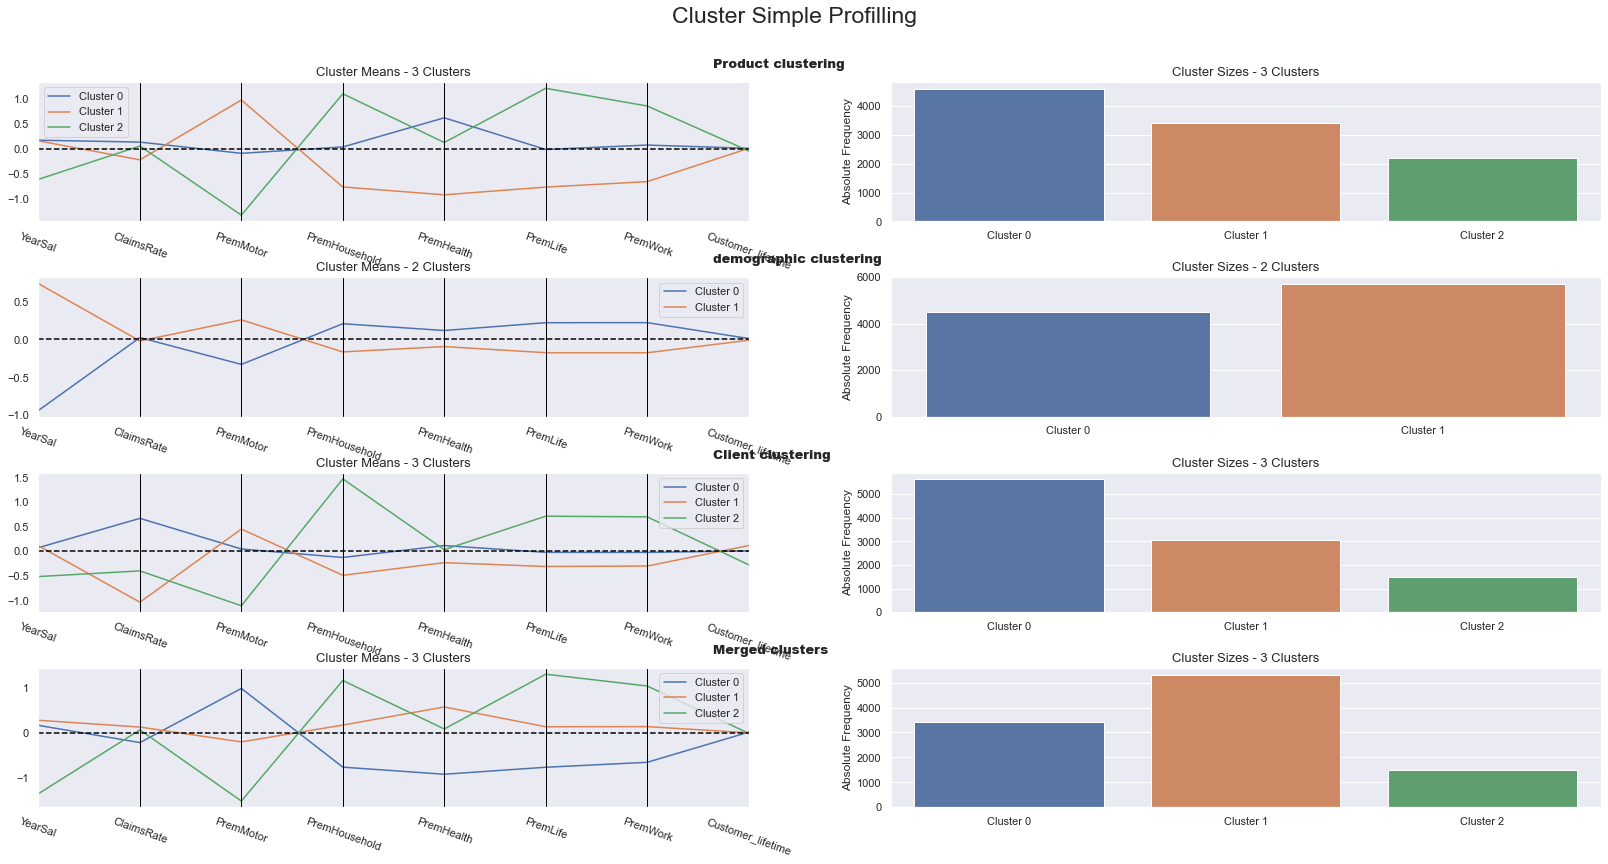

In [189]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df_final[metric_features + ['product_labels', 'demographic_labels', 'client_labels', 'merged_labels']], 
    label_columns = ['product_labels', 'demographic_labels', 'client_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ["Product clustering", "demographic clustering", "Client clustering", "Merged clusters"]
)

In [190]:
two_dim = TSNE(random_state=42).fit_transform(df_final[metric_features])

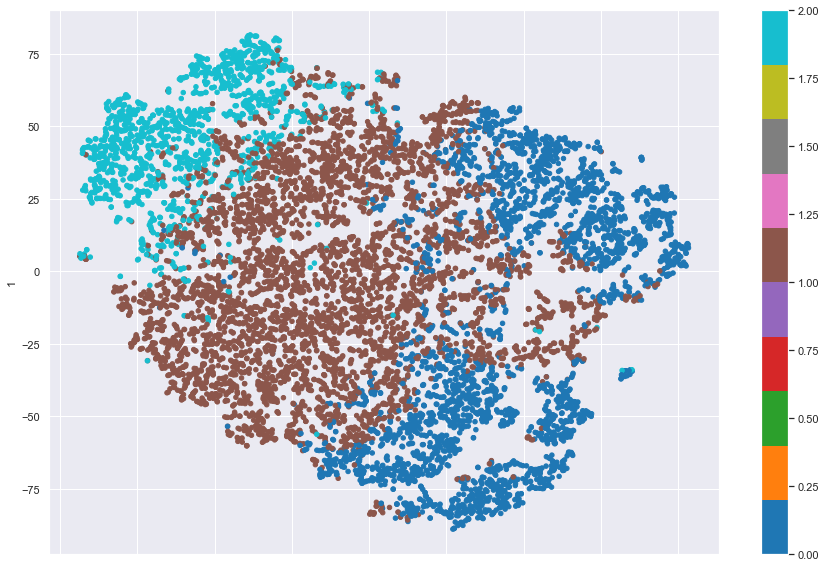

In [191]:
# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df_final['merged_labels'], colormap='tab10', figsize=(15,10))
plt.show()

## Profiling of the Final clustering Solution: 

In [203]:
df['final_labels']=km_labels
df['Effort_Rate']=round(df['TotalPrem']*100/df['YearSal'],2)
df

EducDeg  YearSal  GeoLivArea  Children  CustMonVal  ClaimsRate  \
0            2  26124.0         1.0       1.0      380.97        0.39   
1            2   8124.0         4.0       1.0     -131.13        1.12   
2            1  27324.0         3.0       0.0      504.67        0.28   
3            3  13188.0         4.0       1.0      -16.99        0.99   
4            3  21156.0         4.0       1.0       35.23        0.90   
...        ...      ...         ...       ...         ...         ...   
10217        4  38256.0         2.0       0.0       -0.11        0.96   
10218        1  29172.0         3.0       0.0     1405.60        0.00   
10219        3  35016.0         1.0       1.0      524.10        0.21   
10220        1  23652.0         2.0       1.0      250.05        0.65   
10221        4  33780.0         1.0       1.0      463.75        0.27   

       PremMotor  PremHousehold  PremHealth  PremLife  PremWork  TotalPrem  \
0         375.85          79.45      146.36     47.01     16.89     665.56   
1          77.46         416.20      116.69    194.48    106.13     910.96   
2         206.15         224.50      124.58     86.35     99.02     740.60   
3         182.48          43.35      311.17     35.34     28.34     600.68   
4         338.62          47.80      182.59     18.78     41.45     629.24   
...          ...            ...         ...       ...       ...        ...   
10217     393.74          49.45      173.81      9.78     14.78     641.56   
10218     133.58        1035.75      143.25     12.89    105.13    1430.60   
10219     403.63         132.80      142.25     12.67      4.89     696.24   
10220     188.59         211.15      198.37     63.90    112.91     774.92   
10221     414.08          94.45      141.25      6.89     12.89     669.56   

       Customer_lifetime  final_labels  Effort_Rate  
0                   31.0             2         2.55  
1                   35.0             1        11.21  
2                   25.0             1         2.71  
3                   26.0             0         4.55  
4                   30.0             0         2.97  
...                  ...           ...          ...  
10217               32.0             0         1.68  
10218               39.0             1         4.90  
10219               22.0             2         1.99  
10220               35.0             1         3.28  
10221               26.0             2         1.98  

[10222 rows x 15 columns]

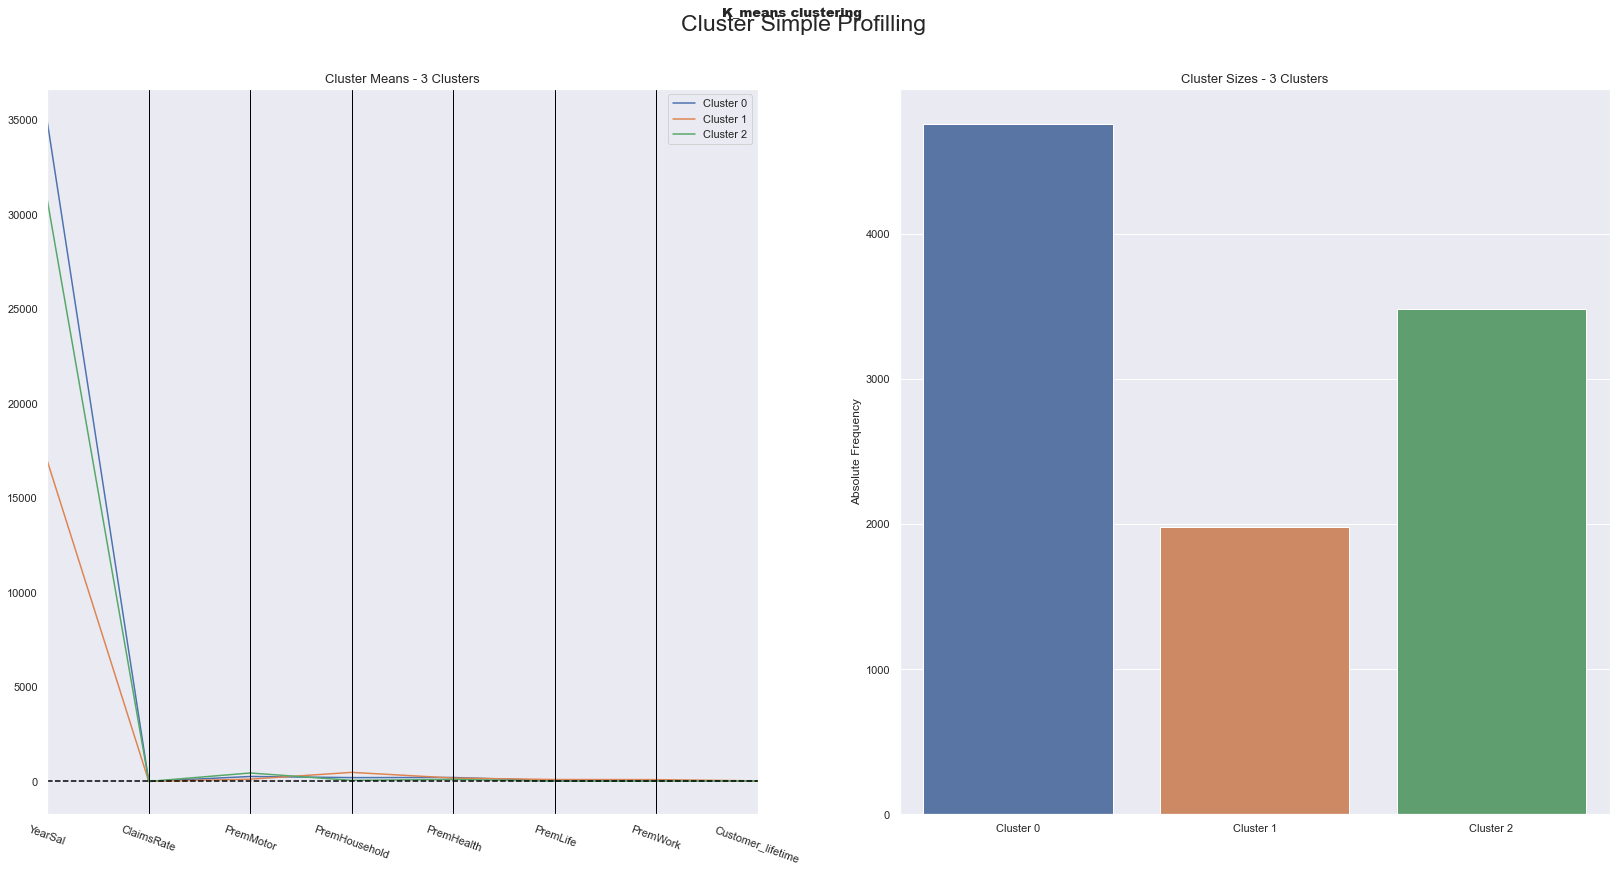

In [193]:
cluster_profiles(
    df = df[metric_features + ['final_labels']], 
    label_columns = ['final_labels'], 
    figsize = (28, 13), 
    compar_titles = ["K_means clustering"]
)

In [204]:
df_scaled['final_labels']=km_labels
two_dim = TSNE(random_state=42).fit_transform(df_scaled[metric_features])

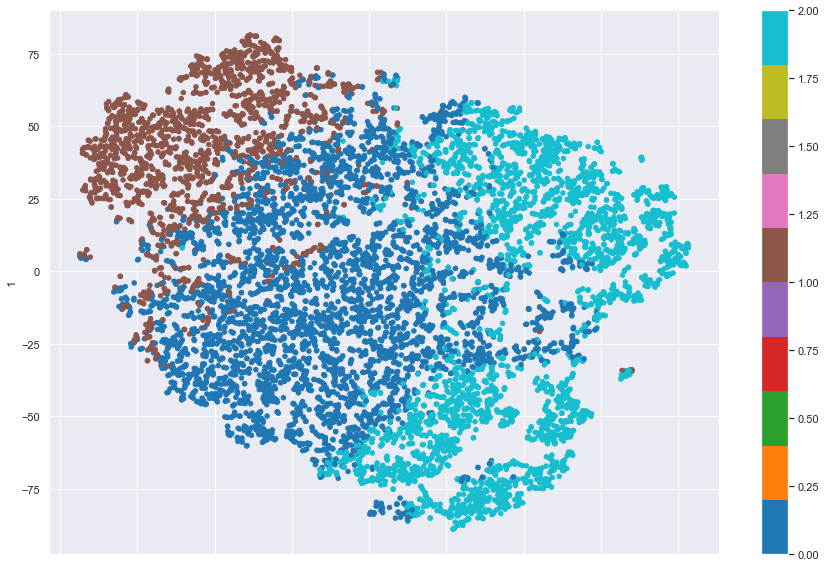

In [207]:
# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df_scaled['final_labels'], colormap='tab10', figsize=(15,10))
plt.show()

In [213]:
df["final_labels"].replace({0: "Cluster 1", 1: "Cluster 2", 2:"Cluster 3"}, inplace=True)

In [195]:
metric = df[metric_features+['CustMonVal', 'TotalPrem', 'Effort_Rate','final_labels']].groupby('final_labels').mean()
metric

YearSal  ClaimsRate   PremMotor  PremHousehold  PremHealth  \
final_labels                                                                    
Cluster 1     34874.955881    0.734659  260.752347     201.292456  208.453299   
Cluster 2     16942.307472    0.694992  119.186658     478.695432  178.880853   
Cluster 3     30737.030282    0.597343  445.446252      55.864618  104.663113   

               PremLife   PremWork  Customer_lifetime  CustMonVal   TotalPrem  \
final_labels                                                                    
Cluster 1     39.243375  39.715890          29.990544  180.310448  749.457367   
Cluster 2     99.409258  94.231676          29.843513  284.106355  970.403877   
Cluster 3     11.362814  11.017019          30.060023  229.821238  628.353817   

              Effort_Rate  
final_labels               
Cluster 1        2.429153  
Cluster 2        7.263786  
Cluster 3        2.230841

In [196]:
global_mean=df[metric_features+['CustMonVal', 'TotalPrem', 'Effort_Rate']].mean()
global_mean=global_mean.to_frame()
global_mean=global_mean.transpose()
global_mean.rename(index={0:'Global Mean'},inplace=True)
global_mean

YearSal  ClaimsRate   PremMotor  PremHousehold  PremHealth  \
Global Mean  29990.115983    0.680197  296.230976     205.514288  167.367363   

             PremLife   PremWork  Customer_lifetime  CustMonVal   TotalPrem  \
Global Mean  41.40621  40.505002          29.985717  217.291104  751.023839   

             Effort_Rate  
Global Mean     3.298541

In [197]:
pd.concat([metric, global_mean])

YearSal  ClaimsRate   PremMotor  PremHousehold  PremHealth  \
Cluster 1    34874.955881    0.734659  260.752347     201.292456  208.453299   
Cluster 2    16942.307472    0.694992  119.186658     478.695432  178.880853   
Cluster 3    30737.030282    0.597343  445.446252      55.864618  104.663113   
Global Mean  29990.115983    0.680197  296.230976     205.514288  167.367363   

              PremLife   PremWork  Customer_lifetime  CustMonVal   TotalPrem  \
Cluster 1    39.243375  39.715890          29.990544  180.310448  749.457367   
Cluster 2    99.409258  94.231676          29.843513  284.106355  970.403877   
Cluster 3    11.362814  11.017019          30.060023  229.821238  628.353817   
Global Mean  41.406210  40.505002          29.985717  217.291104  751.023839   

             Effort_Rate  
Cluster 1       2.429153  
Cluster 2       7.263786  
Cluster 3       2.230841  
Global Mean     3.298541

In [198]:
cat = df[non_metric_features+['final_labels']].groupby('final_labels').agg(pd.Series.mode)
cat

EducDeg  GeoLivArea  Children
final_labels                               
Cluster 1           3         4.0       1.0
Cluster 2           2         4.0       1.0
Cluster 3           3         4.0       1.0

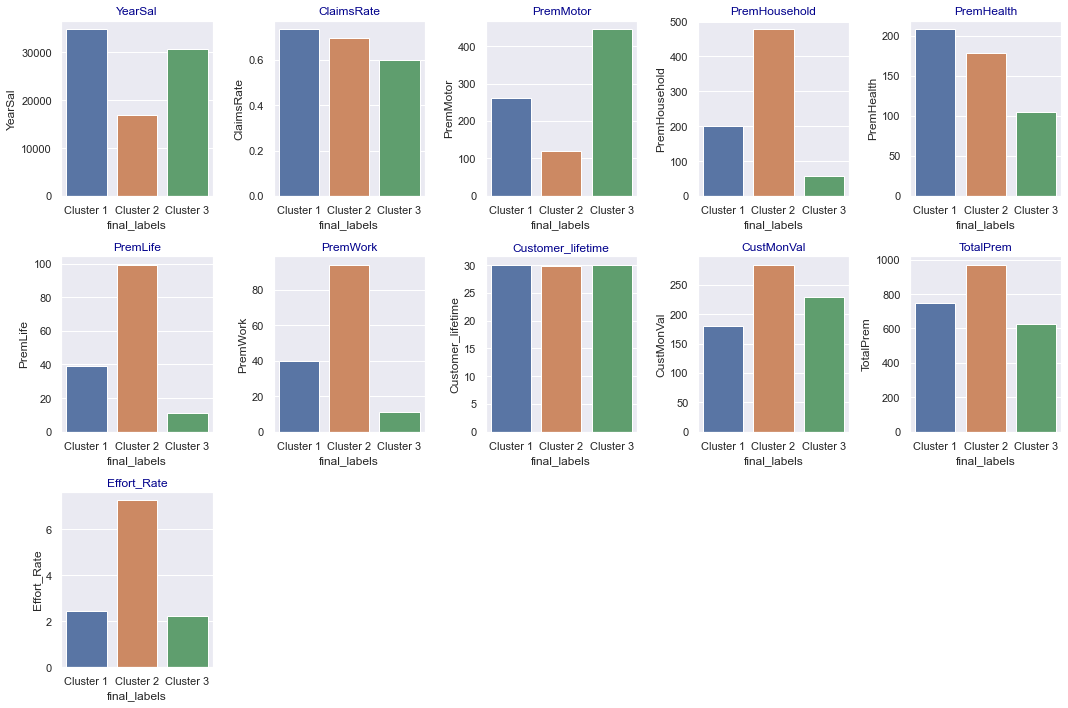

In [199]:
#visualization of the metric features of each cluster 
plt.figure(figsize=(15,10))
for i,j in enumerate(metric_features+['CustMonVal', 'TotalPrem', 'Effort_Rate']):
    plt.subplot(3,5,i+1)
    sns.barplot(metric.index,metric[j])
    plt.title(j,fontdict={'color':'darkblue'})
plt.tight_layout()
plt.show()

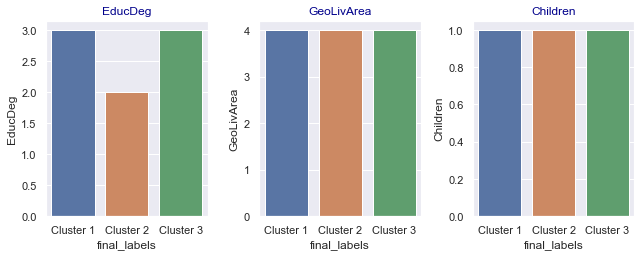

In [200]:
#visualization of the non metric features of each cluster 
plt.figure(figsize=(15,10))
for i,j in enumerate(non_metric_features):
    plt.subplot(3,5,i+1)
    sns.barplot(cat.index,cat[j])
    plt.title(j,fontdict={'color':'darkblue'})
plt.tight_layout()
plt.show()

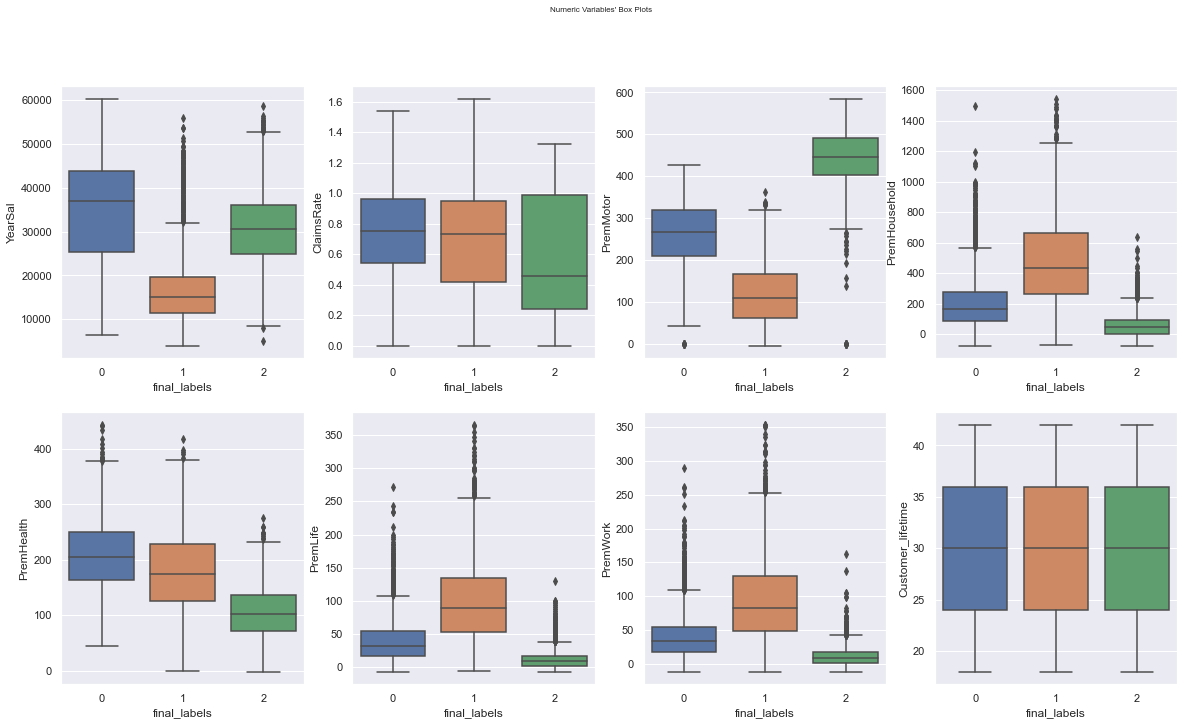

In [208]:
grouped_boxplot("final_labels")

In [214]:
df.loc[df['final_labels']=='Cluster 1'].describe()

EducDeg       YearSal   GeoLivArea     Children   CustMonVal  \
count  4759.000000   4759.000000  4759.000000  4759.000000  4759.000000   
mean      2.490019  34874.955881     2.730826     0.570078   180.310448   
std       0.726499  10966.730825     1.264362     0.495117   208.040230   
min       1.000000   6468.000000     1.000000     0.000000  -298.910000   
25%       2.000000  25254.000000     1.000000     0.000000     1.960000   
50%       3.000000  36888.000000     3.000000     1.000000   165.150000   
75%       3.000000  43764.000000     4.000000     1.000000   310.110000   
max       4.000000  60252.000000     4.000000     1.000000  1150.320000   

        ClaimsRate    PremMotor  PremHousehold   PremHealth     PremLife  \
count  4759.000000  4759.000000    4759.000000  4759.000000  4759.000000   
mean      0.734659   260.752347     201.292456   208.453299    39.243375   
std       0.252844    74.852665     165.436884    61.320976    30.920189   
min       0.000000     0.000000     -75.000000    45.230000    -7.000000   
25%       0.540000   209.260000      87.800000   163.810000    17.560000   
50%       0.750000   266.830000     163.350000   205.150000    32.450000   
75%       0.960000   319.895000     279.500000   249.435000    54.010000   
max       1.540000   427.190000    1498.050000   442.860000   270.940000   

          PremWork    TotalPrem  Customer_lifetime  Effort_Rate  
count  4759.000000  4759.000000        4759.000000  4759.000000  
mean     39.715890   749.457367          29.990544     2.429153  
std      31.977521   137.709115           6.564687     1.062102  
min     -12.000000    55.570000          18.000000     0.160000  
25%      17.505000   656.745000          24.000000     1.670000  
50%      33.230000   723.800000          30.000000     2.130000  
75%      54.065000   815.930000          36.000000     2.900000  
max     289.720000  1796.440000          42.000000    11.680000

In [215]:
df.loc[df['final_labels']=='Cluster 2'].describe()

EducDeg       YearSal   GeoLivArea     Children   CustMonVal  \
count  1981.000000   1981.000000  1981.000000  1981.000000  1981.000000   
mean      1.841999  16942.307472     2.690560     0.760727   284.106355   
std       0.738394   8611.755891     1.277884     0.426747   352.297599   
min       1.000000   3996.000000     1.000000     0.000000  -490.200000   
25%       1.000000  11436.000000     1.000000     1.000000    16.230000   
50%       2.000000  15060.000000     3.000000     1.000000   201.700000   
75%       2.000000  19728.000000     4.000000     1.000000   510.660000   
max       4.000000  55908.000000     4.000000     1.000000  1571.760000   

        ClaimsRate    PremMotor  PremHousehold   PremHealth     PremLife  \
count  1981.000000  1981.000000    1981.000000  1981.000000  1981.000000   
mean      0.694992   119.186658     478.695432   178.880853    99.409258   
std       0.316644    69.308329     291.326889    69.840602    63.157890   
min       0.000000    -4.110000     -70.000000     0.000000    -6.000000   
25%       0.420000    62.900000     263.950000   125.580000    53.010000   
50%       0.730000   108.910000     432.850000   173.700000    89.240000   
75%       0.950000   167.700000     663.450000   227.820000   134.580000   
max       1.620000   362.180000    1544.750000   417.080000   365.180000   

          PremWork    TotalPrem  Customer_lifetime  Effort_Rate  
count  1981.000000  1981.000000        1981.000000  1981.000000  
mean     94.231676   970.403877          29.843513     7.263786  
std      62.089014   236.860828           6.702762     4.530628  
min     -12.000000   222.150000          18.000000     0.710000  
25%      47.900000   799.480000          24.000000     4.350000  
50%      82.680000   937.520000          30.000000     6.150000  
75%     129.690000  1121.880000          36.000000     8.880000  
max     353.180000  1809.690000          42.000000    36.510000

In [216]:
df.loc[df['final_labels']=='Cluster 3'].describe()

EducDeg       YearSal   GeoLivArea     Children   CustMonVal  \
count  3482.000000   3482.000000  3482.000000  3482.000000  3482.000000   
mean      2.828834  30737.030282     2.695864     0.865020   229.821238   
std       0.684709   8436.149814     1.263016     0.341751   239.160853   
min       1.000000   4980.000000     1.000000     0.000000  -192.000000   
25%       2.000000  24876.000000     1.000000     1.000000   -21.860000   
50%       3.000000  30486.000000     3.000000     1.000000   311.955000   
75%       3.000000  36024.000000     4.000000     1.000000   444.697500   
max       4.000000  58596.000000     4.000000     1.000000   972.530000   

        ClaimsRate    PremMotor  PremHousehold   PremHealth     PremLife  \
count  3482.000000  3482.000000    3482.000000  3482.000000  3482.000000   
mean      0.597343   445.446252      55.864618   104.663113    11.362814   
std       0.377828    64.958553      78.654619    46.518313    13.441402   
min       0.000000     0.000000     -75.000000    -2.110000    -7.000000   
25%       0.240000   403.630000       0.000000    71.570000     2.000000   
50%       0.460000   445.140000      45.000000   102.075000     8.780000   
75%       0.990000   492.482500      94.450000   136.165000    16.780000   
max       1.320000   585.220000     637.350000   274.940000   129.470000   

          PremWork    TotalPrem  Customer_lifetime  Effort_Rate  
count  3482.000000  3482.000000        3482.000000  3482.000000  
mean     11.017019   628.353817          30.060023     2.230841  
std      14.173127    79.360558           6.612873     0.834891  
min     -12.000000     0.000000          18.000000     0.000000  
25%       1.000000   580.000000          24.000000     1.700000  
50%       9.000000   625.560000          30.000000     2.060000  
75%      17.450000   669.000000          36.000000     2.540000  
max     162.920000  1090.880000          42.000000    13.560000